# load the same setup for the ASTE 90

This notebook will try to load the Jterms from the layers package and see if we replicated these correctly.

I die.

We already verified that JtermsT and JtermsS are the same as the output from layers so we can try again to look at the comparison to gates.

In [1]:
# auto-reload edited modules
%load_ext autoreload
%autoreload 2

import sys, os
sys.path.insert(0, "/home/mmurakami/crios_backups/an_helper_functions")

# run the script into the current kernel (vars/functions become available)
%run -i "/home/mmurakami/crios_backups/an_helper_functions/load_packages.py"

(50,) (50, 1350, 270)
hf1 (1350, 270)
(1, 1350, 270)
LwetC2d 146614
LwetC 4833023



In [2]:
# set the parameters for the astxfe 90 grid
nx = 90
ncut1 = 150
ncut2 = 60
ny = 2*ncut1 + nx + ncut2
nz = 50
nfx = np.array([nx,0,nx,ncut2,ncut1])
nfy = np.array([ncut1, 0, nx,nx,nx])

In [3]:
dirroot = "/scratch3/atnguyen/aste_90x150x60/"
dirgrid = dirroot + "GRID_real8/"
dirgridnb = dirroot + "GRID_noblank/"
runstr= "run_c68v_heffmosm3x_layers_lessmem1_viscAHp5em2_it0000_pk0000000001/"
layers_path = dirroot + runstr
extL = "LAYERS"
dirmask = dirroot + "run_template/input_maskTransport/"
dirdiags = layers_path + "diags/BUDG/"
dirstate = layers_path + "diags/STATE/"

In [4]:
# 126-130
xc = mygrid['XC']
yc = mygrid['YC']
rac = mygrid['RAC']
drf = mygrid['DRF']

In [5]:
nx = 90
ncut1 = 150
ncut2 = 60
ny = 2*ncut1+nx+ncut2   # this is 450
nz = 50
nfx = np.array([nx, 0 , nx, ncut2 ,ncut1])
nfy = np.array([ncut1, 0 , nx, nx, nx])

mygrid = {
    'dirGrid': dirgrid,
    'nFaces': 5,
    'fileFormat': 'compact',
    'memoryLimit': 2,
    'ioSize': [nx*ny, 1],
    'facesSize': [ny, nx],
    'facesExpand': [ny, nx],
    'missVal': 0,
}

fldstr2d = ['XC','YC','RAC','Depth','maskInC','DXG','DYG']#,'DXC','DYC'] # 'XG','YG'
fldstr3d = ['hFacC'] #,'hFacW','hFacS','mskC','mskS','mskW']
fldstr3dp = ['hFacC'] # ,'hFacW','hFacS','maskCtrlC','maskCtrlS','maskCtrlW']
fldstr1d = ['RC','DRF','RF'] # ,'RF','DRC',

for fld in fldstr1d:
    mygrid[fld] = np.squeeze(rdmds(os.path.join(dirgrid, fld)))

for fld in fldstr3d:
    temp = rdmds(os.path.join(dirgrid, fldstr3dp[fldstr3d.index(fld)]))
    mygrid[fld] = temp.reshape(nz, ny, nx)

for fld in fldstr2d:
    temp = rdmds(os.path.join(dirgrid, fld))
    mygrid[fld] = temp.reshape(ny, nx)

# mygrid['mskC'][mygrid['mskC'] == 0] = np.nan
RAC = mygrid['RAC']
mskC = mygrid['maskInC']

In [6]:
hf_aste = get_aste_tracer(hf1[0],nfx,nfy)

In [7]:
d = rdmds(dirgrid + "Depth",-1)
d = np.reshape(d,(ny,nx))
class structtype():
    pass
fld = d
print(fld.shape)
dep_aste = get_aste_tracer(d,nfx,nfy)
dep_compact = aste_tracer2compact(dep_aste,nfx,nfy)
np.sum(d-dep_compact)  # this should be 0 if we did the back and forth correctly

(450, 90)


0.0

In [8]:
# obcs
mygrid['hFacC'][mygrid['hFacC'] > 0] = 1
mygrid['hFacC'][mygrid['hFacC'] == 0] = np.nan
hf1 = mygrid['hFacC'][0] # top layer in z
# hf1 = hf1[np.newaxis,:, :]
print(hf1.shape)

hf1 = get_aste_tracer(hf1, nfx, nfy)

# check with hardcoding on this for mini or big aste
if nx == 90:
    hf1[:,281,:] = np.nan
    hf1[:,7,:] = np.nan
    hf1[:,86,122] = np.nan
elif nx == 270:
    hf1[:,844,:] = np.nan
    hf1[:,23,:] = np.nan
    hf1[:,365,260:261] = np.nan

hf1 = aste_tracer2compact(hf1,nfx,nfy)[0]
hf = mygrid["hFacC"]
hf = hf * np.tile(hf1,(nz, 1,1))

print(hf.shape,hf1.shape)

(450, 90)
(50, 450, 90) (450, 90)


In [9]:
filename = "layers2TH"
boundsT = rdmds(layers_path + filename)
binsTH_edges = boundsT.reshape(boundsT.shape[0])
binsTH_centers = (binsTH_edges[:-1] + binsTH_edges[1:])/2
nT = binsTH_edges.shape[0]-1

filename = "layers1SLT"
boundsS = rdmds(layers_path + filename)
binsSLT_edges = boundsS.reshape(boundsS.shape[0])
binsSLT_centers = (binsSLT_edges[:-1] + binsSLT_edges[1:])/2
nS = binsSLT_edges.shape[0]-1

binwidthT = binsTH_edges[1:] - binsTH_edges[:-1]
binwidthS = binsSLT_edges[1:] - binsSLT_edges[:-1]

binwidthT1 = (binwidthT[:-1] + binwidthT[1:])/2
binwidthS1 = (binwidthS[:-1] + binwidthS[1:])/2

binmidT = ((boundsT[:-1] + boundsT[1:])/2).reshape(nT)
binmidS = ((boundsS[:-1] + boundsS[1:])/2).reshape(nT)

In [10]:
# 2d
rac2d = read_float64(dirgrid + "RAC" + ".data")
print("RAC2d",rac2d.shape)

drf3d = read_float32(dirgrid + "DRF" + ".data")


rac2dtile = np.tile(rac2d,(nT-1,1)) #.shape

hf1flat = np.reshape(hf1,hf1.flatten().shape[0])
hf2d = hf1flat

hf2dtile = np.tile(hf2d,(nT-1,1))
ffac = 1e-6

RAC2d (40500,)
(100,)


In [11]:
# we're not using iWetC2d because I'm not sure where this went for the ASTE 90 grid
ts = "0000000003"
tsstr = np.array([ts])

# load the mask and the gates for the Barents Sea 

In [12]:
# try to use rdmds
fileprefix = "/scratch3/atnguyen/aste_90x150x60/"
extBasin='run_template/input_maskTransport/'
filename = fileprefix + extBasin + "GATE_transports_v2_mskBasin.bin"
ind = np.fromfile(filename, dtype=np.int32)  # auto-reads .meta for shape/dtype/order
orig_shape = (ind.shape)

ind2d = ind.reshape(ny,nx)

mymsk = np.full((ny,nx),np.nan)
mymsk[ind2d == 57408.0] = 1

# make this smaller
mymsk[:,27:50] = np.nan
mymsk[:160,12:30] = np.nan
mymsk[160:163,15:30] = np.nan

In [13]:
landmsk = np.zeros((ny,nx))
landmsk[hf1 == 0] = 1
landmsk[hf1 == 1] = np.nan

In [14]:
ind = ind.reshape(ny,nx)


mymsk = np.full((ny,nx),np.nan)
mymsk[ind == 57408.0] = 1

# make this smaller
mymsk[:,27:50] = np.nan
mymsk[:160,12:30] = np.nan
mymsk[160:163,15:30] = np.nan

In [15]:
ysmsk,xsmsk = np.where(mymsk==1)[0],np.where(mymsk==1)[1]
# np.nanmax(ysmsk)

In [16]:
# redefine the gateways here and make sure these are correct

# these are the indices we want to read from, but not write to
# at y = 186, we want -ADVy
x_bsoh = np.array([54, 54, 54, 54, 54])
x_bsov = np.array([0,  1,  2,  3,  4,  5,  6,  7,  8,  9])    # from Norway to Sp
y_bsoh = np.array([145, 146, 147, 148, 149])
y_bsov = np.array([186, 186, 186, 186, 186, 186, 186, 186, 186, 186])    # from Norway to Sp

x_spfjh = np.array([20,20,20,23,24,24,26,26])    # vertical gates from Sp to Fj as -x
y_spfjh = np.array([185,184,183,182,181,180,179,178])
x_spfjv = np.array([20,21,22,23,24,25,26])          # horizontal gates where we want to read -y
y_spfjv = np.array([183,183,183,183,182,180,180])

y_fjnzv = np.arange(165,175,1)
x_fjnzv = np.full_like(y_fjnzv,27)    # horizontal gate where we want to read -x

y_nzruv = np.arange(152,155,1)
x_nzruv = np.full_like(y_nzruv,12)   # horizontal gate where we want to read -x


In [17]:
# gates_mask starts as NaN everywhere
gates_mask = np.full((ny, nx), np.nan, dtype=float)

def _mark_points(mask, xs, ys, code, ny, nx, name="gate"):
    """
    Mark (y, x) points in mask with 'code'.
    If a point already has a different non-NaN code, set it to 3 (overlap).
    Bounds are clipped to the grid silently.
    """
    xs = np.asarray(xs)
    ys = np.asarray(ys)

    if xs.shape != ys.shape:
        raise ValueError(f"{name}: x/y length mismatch: {xs.shape} vs {ys.shape}")

    # clip to valid indices just in case
    xi = np.clip(xs.astype(int), 0, nx-1)
    yi = np.clip(ys.astype(int), 0, ny-1)

    for j, i in zip(yi, xi):
        cur = mask[j, i]
        if np.isnan(cur):
            mask[j, i] = code
        elif cur == code or cur == 3:
            # already same code or already overlap — leave as is
            continue
        else:
            mask[j, i] = 3  # overlap with different code
    return mask

# ---- mark H gates with code = 1 ----
gates_mask = _mark_points(gates_mask, x_bsoh, y_bsoh, 1, ny, nx, name="bsoh")
gates_mask = _mark_points(gates_mask, x_spfjh, y_spfjh, 1, ny, nx, name="spfjh")

# ---- mark V gates with code = 2 ----
gates_mask = _mark_points(gates_mask, x_bsov,  y_bsov,  2, ny, nx, name="bsov")
gates_mask = _mark_points(gates_mask, x_spfjv, y_spfjv, 2, ny, nx, name="spfjv")
gates_mask = _mark_points(gates_mask, x_fjnzv, y_fjnzv, 1, ny, nx, name="fjnzv")
gates_mask = _mark_points(gates_mask, x_nzruv, y_nzruv, 1, ny, nx, name="nzruv")

# Optional: if you prefer 0 instead of NaN for “not a gate”
# gates_mask = np.nan_to_num(gates_mask, nan=0.0)

In [18]:
# let's make a mask of these to double check that we did this correctly

gates_mask[182,23] = 3
gates_mask[180,24] = 3
gates_mask[180,26] = np.nan
gates_mask[182,24] = np.nan
gates_mask[183,23] = np.nan

In [19]:
mymsk_1d = mymsk.reshape(orig_shape, order='C')
mymsk3d = np.tile(mymsk[np.newaxis,:,:],(nz,1,1))

(150.0, 200.0)

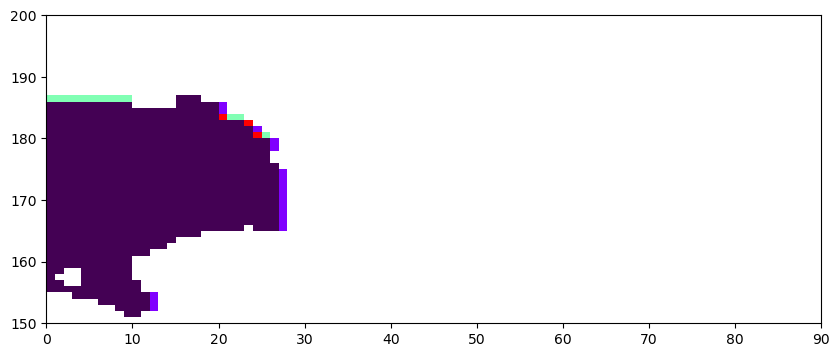

In [20]:
# again the gates are the indices we want to read from, but not write to
plt.pcolormesh(mymsk)
plt.pcolormesh(gates_mask,cmap='rainbow')
# plt.xlim(140,180)
plt.ylim(150,200)

In [21]:
landmsk.shape

(450, 90)

(140.0, 200.0)

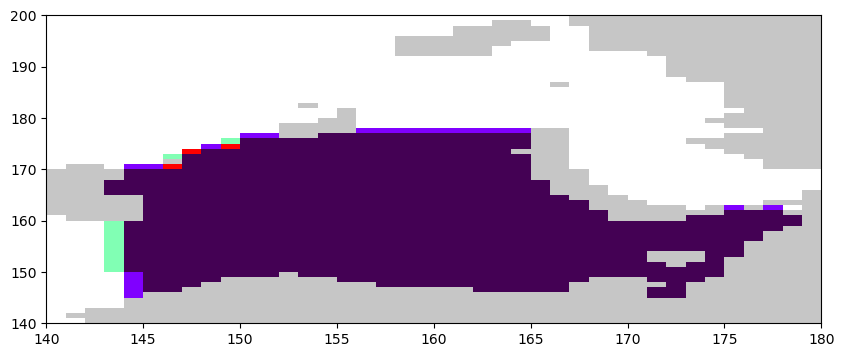

In [22]:
# again the gates are the indices we want to read from, but not write to
plt.pcolormesh(get_aste_tracer(mymsk,nfx,nfy)[0])
plt.pcolormesh(get_aste_tracer(gates_mask,nfx,nfy)[0],cmap='rainbow')
plt.pcolormesh(get_aste_tracer(landmsk,nfx,nfy)[0],cmap="Greys",vmin=-2,vmax=4)
plt.xlim(140,180)
plt.ylim(140,200)

## Load dv/dt for the Barents Sea based on the ETAN and mass budget

In [23]:
tsstr = np.array(['0000000002','0000000003'])
RAC3 = np.tile(mygrid['RAC'][np.newaxis,:,:],(nz,1,1))
hfC = mygrid['hFacC']

DD = mygrid['Depth']

DD3d = mk3D_mod(DD,np.zeros((nz, ny, nx)))


In [24]:
file_name = 'budg2d_snap_set1'
meta_budg2d_snap_set1 = parsemeta(dirdiags + file_name + "." + tsstr[0] + ".meta")

# try to read this with rec
fldlist = np.array(meta_budg2d_snap_set1['fldList'])
varnames = np.array(['ETAN','PHIBOT','SIheff','SIhsnow'])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    recs = np.append(recs, irec[0][0])

ETAN = np.full((len(tsstr),ny,nx),np.nan)
PHIBOT = np.full((len(tsstr),ny,nx),np.nan)
SIheff = np.full((len(tsstr),ny,nx),np.nan)
SIhsnow = np.full((len(tsstr),ny,nx),np.nan)

for i in range(len(tsstr)):
    thisETAN,its,meta = rdmds(os.path.join(dirdiags, file_name),int(tsstr[i]),returnmeta=True,rec=recs[0])
    thisETAN = thisETAN.reshape(ny,nx)
    ETAN[i] = thisETAN

    thisPHIBOT,its,meta = rdmds(os.path.join(dirdiags, file_name),int(tsstr[i]),returnmeta=True,rec=recs[1])
    thisPHIBOT = thisPHIBOT.reshape(ny,nx)
    PHIBOT[i] = thisPHIBOT

    thisSIheff,its,meta = rdmds(os.path.join(dirdiags, file_name),int(tsstr[i]),returnmeta=True,rec=recs[2])
    thisSIheff = thisSIheff.reshape(ny,nx)
    SIheff[i] = thisSIheff

    thisSIhsnow,its,meta = rdmds(os.path.join(dirdiags, file_name),int(tsstr[i]),returnmeta=True,rec=recs[3])
    thisSIhsnow = thisSIhsnow.reshape(ny,nx)
    SIhsnow[i] = thisSIhsnow

dETANdt =  (ETAN[1, :, :] - ETAN[0, :, :]) / dt

In [25]:
# 3D, with rStar:
# mk3D_mod function should be called here but I might be doing it wrong
tmptend = np.zeros((nz, ny, nx))
if myparms['useNLFS'] < 2 or myparms['rStar'] == 0:        # not this time
    tmptend[0,:, :] = ETAN * RAC     # m/s * m  = m^2/s
    if myparms['useRFWF'] == 0:
        tmptend[0, :, :] = np.zeros((ny, nx))
else:
    if myparms['useRFWF'] != 0:                                 # we are using this  # check if tmp1 is the same as drf3d!!
        tmp1 = mk3D_mod(mygrid['DRF'],hfC) * hfC           # m^2
        tmp2 = tmp1/mk3D_mod(DD,tmp1)
    else:
        tmp2 = drf3d / mk3D_mod(DD, tmp1)
        
    tmptend = tmp2 * np.tile(dETANdt[np.newaxis,:,:],(nz,1,1)) * RAC3  # if we just didn't multiply by RAC this would be in m/s
    # does that change anything?
    vol1 =  tmp2 * np.tile(ETAN[1,:,:],(nz,1,1)) * RAC3
    vol0 =  tmp2 * np.tile(ETAN[0,:,:],(nz,1,1)) * RAC3

In [26]:
# RAC3

array([[[7.11171050e+09, 7.11171050e+09, 7.11171050e+09, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [7.24830186e+09, 7.24830186e+09, 7.24830186e+09, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [7.38529340e+09, 7.38529340e+09, 7.38529340e+09, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        ...,
        [3.58435154e+09, 3.67789783e+09, 3.77325366e+09, ...,
         1.09446652e+10, 1.08674288e+10, 1.07857762e+10],
        [1.06998558e+10, 1.06098218e+10, 1.05158332e+10, ...,
         6.70544648e+09, 6.84017716e+09, 6.97563284e+09],
        [7.11171050e+09, 7.24830187e+09, 7.38529340e+09, ...,
         7.38529340e+09, 7.24830186e+09, 7.11171050e+09]],

       [[7.11171050e+09, 7.11171050e+09, 7.11171050e+09, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [7.24830186e+09, 7.24830186e+09, 7.24830186e+09, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [7.38529340e+09, 

In [27]:
# we need to also create the theta and salt bins for this area

t2 = int(tsstr[1])
# 'diags/state_3d_set1'
# read theta and salt averages from the t2 timestep (average)
file_name = "state_3d_set1"
meta_state_3d_set1 = parsemeta(dirstate + file_name + "." + tsstr[0] + ".meta")
fldlist = np.array(meta_state_3d_set1["fldList"])
varnames = np.array(["THETA","SALT"])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    recs = np.append(recs, irec[0][0])
THETA,its,meta = rdmds(os.path.join(dirstate, file_name),t2,returnmeta=True,rec=recs[0])
SALT,its,meta = rdmds(os.path.join(dirstate, file_name),t2,returnmeta=True,rec=recs[1])

THETA = THETA.reshape(nz,ny,nx)
SALT = SALT.reshape(nz,ny,nx)

In [28]:
# we want to bin theta and salt into the T and S bins
binned_theta = bin_array(THETA,binsTH_centers)
binned_theta = binned_theta.astype(float)
binned_theta[binned_theta == nT] = np.nan     # because the binning is setting nan to last value
binned_salinity = bin_array(SALT,binsSLT_centers)
binned_salinity = binned_salinity.astype(float)
binned_salinity[binned_salinity == nS] = np.nan

In [29]:

def create_TS_mesh(tsstr,nS,nT,npoints, binned_salinity, binned_theta, attr,idxs):
    '''
    Inputs:
        nS: binsSLT_edges.shape[0]-1
        nT: binsTH_edges.shape[0]-1
        binned_salinity: the array of shape nz, ny, nx of the indices of salinity in the salt bins
        binned_theta: same as above but for theta
        attr: the attribute we want to bin, ie advection, diffusion etc.
        idxs: np.where(mymsk == iB) or whatever indices in mskBasin we are looking at

    Outputs:
        returns an nS by nT shaped array with the summed values within the attr (like volume)
    '''
    
    mesh = np.zeros((len(tsstr),nS, nT, npoints))
    tn = 0
    for t in range(len(tsstr)):
        if len(attr.shape) == 4:
            # time x nz x ny x nx
            thisvol = attr[t][:,idxs[0],idxs[1]]
            thissalt = binned_salinity[t][:,idxs[0],idxs[1]]
            thistemp = binned_theta[t][:,idxs[0],idxs[1]]
        elif len(attr.shape) == 3:
            # time x ny x nx
            thisvol = attr[t][idxs[0],idxs[1]]
            thissalt = binned_salinity[t][idxs[0],idxs[1]]
            thistemp = binned_theta[t][idxs[0],idxs[1]]
            
        # trim the nan values
        thisvol = np.where(np.isnan(thisvol), 0, thisvol)
        thissalt = np.where(np.isnan(thissalt), -1, thissalt)  # Replace NaN with -1
        thistemp = np.where(np.isnan(thistemp), -1, thistemp)
        
        # create the mesh
        meshx = np.zeros((nS,nT,npoints))
        
        # create local timed mesh
        np.add.at(meshx, ( thissalt.astype(int), thistemp.astype(int), np.arange(0,npoints,1)), thisvol[...])  # this should work to add at bins
        
        # add to big mesh
        mesh[tn,:,:,:] = meshx
        del meshx

        tn += 1
    return mesh

In [30]:
idxs = np.where(mymsk==1)
npoints = len(idxs[0])

In [31]:
# plot the tmptend as normalized by binwidthT1 and binwidthS1
dVdt = create_TS_mesh(tsstr[:-1],nS-1,nT-1,npoints,binned_salinity.reshape(1,nz,ny,nx), binned_theta.reshape(1,nz,ny,nx),tmptend.reshape(1,nz,ny,nx),idxs)

In [32]:
dVdt = np.nansum(dVdt[0],axis=2)  # this is already in m^3/s

In [33]:
# get volume totally

bTS1 = create_TS_mesh(tsstr[:-1],nS-1,nT-1,npoints,binned_salinity.reshape(1,nz,ny,nx), binned_theta.reshape(1,nz,ny,nx),vol1.reshape(1,nz,ny,nx),idxs)
bTS0 = create_TS_mesh(tsstr[:-1],nS-1,nT-1,npoints,binned_salinity.reshape(1,nz,ny,nx), binned_theta.reshape(1,nz,ny,nx),vol0.reshape(1,nz,ny,nx),idxs)
bTS = np.nansum(bTS1[0],axis=2)

In [34]:
RACbin = create_TS_mesh(tsstr[:-1],nS-1,nT-1,npoints,binned_salinity.reshape(1,nz,ny,nx), binned_theta.reshape(1,nz,ny,nx),RAC3.reshape(1,nz,ny,nx),idxs)
RACbin = np.nansum(RACbin[0],axis=2)


In [36]:
# plt.pcolormesh(Sbin,Tbin,RACbin,vmin=0,vmax=1e12)
# plt.colorbar()

In [37]:
binwidthT1tile = np.tile(binwidthT1[np.newaxis,:],(nT-1,1))
binwidthS1tile = np.tile(binwidthS1[:,np.newaxis],(1,nS-1))

In [38]:
Tbin,Sbin = np.meshgrid(binsTH_centers,binsSLT_centers)

In [39]:
# binned_salinity

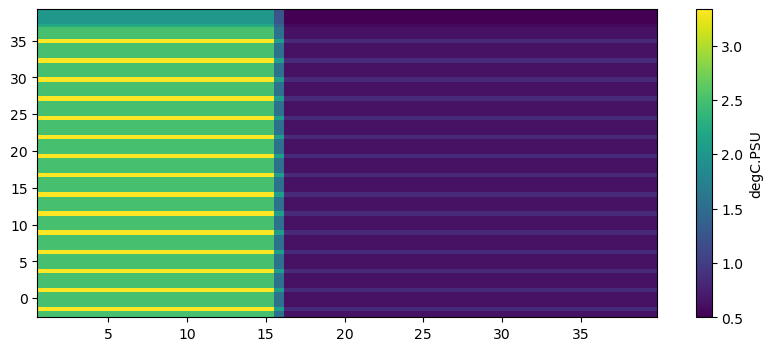

In [40]:
plt.pcolormesh(Sbin,Tbin,binwidthS1tile / binwidthT1tile)
plt.colorbar(label="degC.PSU")

In [41]:
print(np.nansum(tmptend*mymsk3d))
print(np.nansum(dVdt))  # this confirms that the volume change in the basin is the same as the volume change in the TS diagram

-295.9784756385046
-295.97847563850223


Text(0.5, 1.0, 'total volume tend')

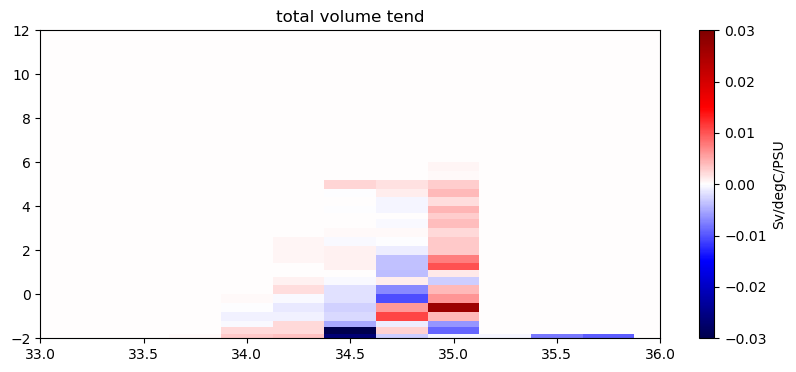

In [42]:
fig = plt.figure()

ax = plt.subplot(111)
cb = ax.pcolormesh(Sbin,Tbin,dVdt * 1e-6 / binwidthS1tile / binwidthT1tile,cmap='seismic',vmin=-.03,vmax=0.03)
plt.colorbar(cb,label="Sv/degC/PSU")
ax.set_xlim(33,36)
ax.set_ylim(-2,12)
plt.title("total volume tend")

In [43]:
file_name = "budg3d_hflux_set2"
meta_budg3d_hflux_set2 = parsemeta(dirdiags + file_name + "." + tsstr[0] + ".meta")
fldlist = np.array(meta_budg3d_hflux_set2["fldList"])
varnames = np.array(["ADVx_TH","ADVy_TH"])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    recs = np.append(recs, irec[0][0])
ADVx_TH,its,meta = rdmds(os.path.join(dirdiags, file_name),t2,returnmeta=True,rec=recs[0])
ADVy_TH,its,meta = rdmds(os.path.join(dirdiags, file_name),t2,returnmeta=True,rec=recs[1])

# now 3d zfluxes
file_name = "budg3d_zflux_set1"
meta_budg3d_zflux_set1 = parsemeta(dirdiags + file_name + "." + tsstr[0] + ".meta")
fldlist = np.array(meta_budg3d_zflux_set1["fldList"])
varnames = np.array(["ADVr_TH"])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    recs = np.append(recs, irec[0][0])
ADVr_TH,its,meta = rdmds(os.path.join(dirdiags, file_name),t2,returnmeta=True,rec=recs[0])
ADVr_TH = ADVr_TH.reshape(nz,ny,nx)

hf = mygrid['hFacC']

ADV_hconv = calc_UV_conv_mod(nfx, nfy,get_aste_faces(ADVx_TH.reshape(nz, ny, nx), nfx, nfy),get_aste_faces(ADVy_TH.reshape(nz, ny, nx), nfx, nfy))
ADV_hconv = ADV_hconv * hf   # degC·m^3/s at cell centers (matches: ff.DFh = ff.DFh .* hf)
ADVhT = ADV_hconv

trWtopADV = -(ADVr_TH)

ADVrT = np.zeros((nz,ny,nx),dtype=float)
ADVrT[:-1,:,:] = (trWtopADV[:-1] - trWtopADV[1:])  # this is not the way we did it in the original code but this is the way An has done it so we try

In [44]:

## do the advective convergence
file_name = "budg3d_hflux_set2"
meta_budg3d_hflux_set2 = parsemeta(dirdiags + file_name + "." + tsstr[0] + ".meta")
fldlist = np.array(meta_budg3d_hflux_set2["fldList"])
varnames = np.array(["DFxE_TH","DFyE_TH"])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    recs = np.append(recs, irec[0][0])
DFxE_TH,its,meta = rdmds(os.path.join(dirdiags, file_name),t2,returnmeta=True,rec=recs[0])
DFyE_TH,its,meta = rdmds(os.path.join(dirdiags, file_name),t2,returnmeta=True,rec=recs[1])


# now 3d zfluxes
file_name = "budg3d_zflux_set1"
meta_budg3d_zflux_set1 = parsemeta(dirdiags + file_name + "." + tsstr[0] + ".meta")
fldlist = np.array(meta_budg3d_zflux_set1["fldList"])
varnames = np.array(["DFrE_TH","DFrI_TH"])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    recs = np.append(recs, irec[0][0])
DFrE_TH,its,meta = rdmds(os.path.join(dirdiags, file_name),t2,returnmeta=True,rec=recs[0])
DFrI_TH,its,meta = rdmds(os.path.join(dirdiags, file_name),t2,returnmeta=True,rec=recs[1])
DFrE_TH = DFrE_TH.reshape(nz,ny,nx)
DFrI_TH = DFrI_TH.reshape(nz,ny,nx)

DF_hconv = calc_UV_conv_mod(nfx, nfy,get_aste_faces(DFxE_TH.reshape(nz, ny, nx), nfx, nfy),get_aste_faces(DFyE_TH.reshape(nz, ny, nx), nfx, nfy))
DF_hconv = DF_hconv * hf   # degC·m^3/s at cell centers (matches: ff.DFh = ff.DFh .* hf)
DFhT = DF_hconv

trWtopDF = -(DFrE_TH+DFrI_TH)

DFrT = np.zeros((nz,ny,nx),dtype=float)
DFrT[:-1,:,:] = (trWtopDF[:-1] - trWtopDF[1:])

In [45]:
# to get the surface term, we need J/s and convert to degC.m^3/s
file_name = 'budg2d_zflux_set1'
meta_budg2d_zflux_set1 = parsemeta(dirdiags + file_name + "." + tsstr[0] + ".meta")
fldlist = np.array(meta_budg2d_zflux_set1["fldList"])
varnames = np.array(["TFLUX","oceQsw","SItflux"])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    recs = np.append(recs, irec[0][0])
TFLUX,its,meta = rdmds(os.path.join(dirdiags, file_name),t2,returnmeta=True,rec=recs[0])
oceQsw,its,meta = rdmds(os.path.join(dirdiags, file_name),t2,returnmeta=True,rec=recs[1])
SItflux,its,meta = rdmds(os.path.join(dirdiags, file_name),t2,returnmeta=True,rec=recs[2])
TFLUX = TFLUX.reshape(ny,nx)
oceQsw = oceQsw.reshape(ny,nx)
SItflux = SItflux.reshape(ny,nx)

# we need to create zconv_top and swtop
dd = mygrid['RF'][:-1]
swfrac = 0.62*np.exp(dd/0.6)+(1-0.62)*np.exp(dd/20)
swfrac[dd < -200] = 0
swtop=mk3D_mod(swfrac,np.zeros((nz,ny,nx)))*mk3D_mod(RAC*oceQsw,np.zeros((nz,ny,nx)))   # J/s

# zconvtop_heat is here
zconv_top_heat = TFLUX * RAC     # W/m^2 * m^2 = J/s

In [46]:

def surface_contrib_JT(zconv_top_heat, swtop, rcp, fill_last=0.0):
    """
    zconv_top_heat: (ny, nx)
    swtop:          (nz, ny, nx)
    rcp:            scalar
    fill_last:      value for bottom slice (k = nz-1), usually 0.0 or np.nan
    returns:
      JsurfT:       (nz, ny, nx)  # Sv / PSU
    """
    nz, ny, nx = swtop.shape

    eT = zconv_top_heat.reshape(1, ny, nx)  # (1,ny,nx) for broadcast

    J = np.empty_like(swtop, dtype=float)

    # k = 0: (eT - fT[1]) / rcp / dT / dS * 1e-6
    J[0] = (eT[0] - swtop[1]) / rcp if np.ndim(binwidthT)==0 else \
           (eT[0] - swtop[1]) / rcp

    # 1 .. nz-2: -(fT[k+1]-fT[k]) / rcp / dT / dS * 1e-6
    J[1:nz-1] = -(swtop[2:nz] - swtop[1:nz-1]) / rcp

    # bottom slice (k = nz-1): no k+1; choose your boundary convention
    J[-1] = fill_last
    return J

Ft_surftestT = surface_contrib_JT(zconv_top_heat,swtop,myparms['rcp'])    # this is in degC.m^3/s

In [47]:
# read kpp tend and from 3d zflux
file_name = "budg3d_kpptend_set1"
meta_budg3d_kpptend_set1 = parsemeta(dirdiags + file_name + "." + tsstr[0] + ".meta")
fldlist = np.array(meta_budg3d_kpptend_set1["fldList"])
varnames = np.array(["KPPg_TH"])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    recs = np.append(recs, irec[0][0])
KPPg_TH,its,meta = rdmds(os.path.join(dirdiags, file_name),t2,returnmeta=True,rec=recs[0])
KPPg_TH = KPPg_TH.reshape(nz,ny,nx)

# do the vertical convergence for KPP
trWtopKPP = -(KPPg_TH)         # degC.m^3/s

tmpkppT = np.full((nz,ny,nx),np.nan)
tmpkppT[:-1,:,:] = trWtopKPP[:-1] - trWtopKPP[1:]

In [48]:
def _bincount_sum_with_nan(idx, vals, nout):
    """
    NaN-aware per-bin sum:
    if *all* entries in a bin are NaN, that bin returns NaN;
    otherwise NaNs are ignored and finite values are summed.
    """
    # track counts of non-nan contributions
    finite = np.isfinite(vals)
    sums   = np.bincount(idx[finite], vals[finite], minlength=nout).astype(float)
    counts = np.bincount(idx[finite], None, minlength=nout).astype(float)
    out = sums
    out[counts == 0] = np.nan
    return out

def plot_figure4_components(
    THETA,
    boundsT,
    binmidT,
    binwidthT1,
    *,
    iiT=None,
    mask=None,
    tendency_name="tmptend",
    **terms
):
    """
    Bin arbitrary component terms by temperature using binmidT intervals and plot:
      Top panel:   each term vs. T (edge-based, divided by binwidthT1)
      Bottom panel: sum(all components except 'tendency_name') vs the tendency term

    Parameters
    ----------
    THETA : array-like
        Tracer field used for binning. Shape must match each term.
    boundsT : 1D array-like
        Bin *edges* (length nT+1). x-locations will be boundsT[1:-1] (length nT-1).
    binmidT : 1D array-like
        Mid-bin edges used to define intervals: binmidT[i] <= THETA < binmidT[i+1]
        Length nT.
    binwidthT1 : 1D array-like
        Edge bin widths (length nT-1), used to convert summed fluxes to edge-based G.
    iiT : slice or 1D index array, optional
        Selection along the temperature-edge axis (length nT-1). Defaults to all.
    mask : array-like, optional
        Same shape as THETA (and each term). Elements where mask is falsy are ignored.
        If provided, terms are multiplied by mask and NaNs are set to zero for counting.
    tendency_name : str, default 'tmptend'
        The key in **terms that should be treated as the tendency curve on panel 2.
    **terms : dict of name -> array-like
        Component arrays to include (e.g., tmpkpp=..., ADVh=..., vdiff=..., surface=..., etc.)
        All arrays must have the same shape as THETA.

    Notes
    -----
    - The binning follows the “new” interpretation used previously:
        binmidT[i] <= THETA < binmidT[i+1], for i = 0..(nT-2)
      which yields nT-1 edge bins.
    - Each component is summed per bin, then divided by `binwidthT1` to give an
      edge-based G-like quantity per temperature edge.
    """

    # --- validate & prepare shapes ---
    THETA      = np.asarray(THETA)
    boundsT    = np.asarray(boundsT)
    binmidT    = np.asarray(binmidT)
    binwidthT1 = np.asarray(binwidthT1)

    if mask is not None:
        mask = np.asarray(mask)
        if mask.shape != THETA.shape:
            raise ValueError("mask must have the same shape as THETA")

    nT   = boundsT.size - 1
    nTm1 = nT - 1
    if binmidT.size != nT:
        raise ValueError("binmidT must have length nT (= len(boundsT)-1)")
    if binwidthT1.size != nTm1:
        raise ValueError("binwidthT1 must have length nT-1 (= len(boundsT)-2 + 1)")

    # x-locations for edge-based curves (length nT-1)
    x = boundsT[1:-1]

    # default selection
    if iiT is None:
        iiT = slice(None)

    # --- flatten for binning ---
    theta_flat = THETA.ravel()

    # build the bin index via binmidT intervals
    # binmidT[i] <= THETA < binmidT[i+1], i = 0..nT-2
    bin_idx_mid = np.digitize(theta_flat, binmidT, right=False) - 1
    valid_mid   = (bin_idx_mid >= 0) & (bin_idx_mid < nTm1) & np.isfinite(theta_flat)

    # if mask provided, fold it into validity
    if mask is not None:
        valid_mid &= (mask.ravel().astype(bool))

    idx_mid = bin_idx_mid[valid_mid]

    # --- per-term binning and edge conversion ---
    G_terms = {}  # name -> (nT-1,) array
    for name, arr in terms.items():
        arr = np.asarray(arr)
        if arr.shape != THETA.shape:
            raise ValueError(f"term '{name}' must have the same shape as THETA")

        vals = arr.ravel().astype(float)

        # Apply mask behavior similar to your snippets:
        #   multiply by mask, set NaNs to 0 for accumulation, but preserve 'all-NaN' as NaN via helper.
        if mask is not None:
            vals = vals * mask.ravel()

        # NaN-aware bin sums (helper will return NaN for bins with no finite contributions)
        S = _bincount_sum_with_nan(idx_mid, vals[valid_mid], nTm1)

        # Convert to edge-based G by dividing by binwidthT1
        G_terms[name] = S / binwidthT1

    # Separate tendency from components-to-sum
    tend_curve = G_terms.get(tendency_name, None)
    comp_names = [k for k in G_terms.keys() if k != tendency_name]

    # Sum across components (excluding tendency)
    if comp_names:
        G_sum = np.nansum(np.vstack([G_terms[k] for k in comp_names]), axis=0)
    else:
        G_sum = np.full(nTm1, np.nan)

    # --- plot ---
    plt.figure(figsize=(14, 4))

    # Top: every component vs T
    ax1 = plt.subplot(1, 1, 1)
    for name in comp_names:
        ax1.plot(x[iiT], G_terms[name][iiT], linewidth=2, label=name)
    if not comp_names:
        ax1.plot([], [], label="(no components provided)")
    ax1.grid(True)
    ax1.set_xlabel('T')
    ax1.set_ylabel('G_T [m^3/s]')
    ax1.set_title('Components by T (edge-based)')
    ax1.legend(ncol=2)
    ax1.axis('tight')

    plt.tight_layout()

    return G_terms


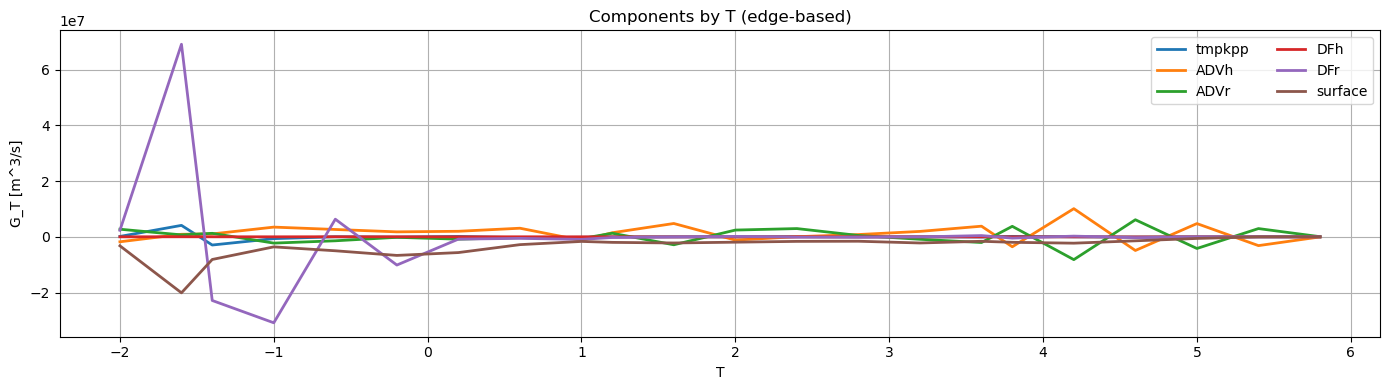

In [49]:
GtermsT = plot_figure4_components(
    THETA,
    boundsT.flatten(),
    binmidT.flatten(),
    binwidthT1.flatten(),
    mask=mymsk3d,                 # optional
    tendency_name="tmptend",      # change if your tendency is named differently
    tmpkpp=tmpkppT,
    ADVh=ADVhT,
    ADVr=ADVrT,
    DFh=DFhT,
    DFr=DFrT,
    surface=Ft_surftestT,
)

In [50]:
GtermsT.keys()

dict_keys(['tmpkpp', 'ADVh', 'ADVr', 'DFh', 'DFr', 'surface'])

## Create the same for the G terms in SALT

In [51]:
file_name = "budg3d_hflux_set2"
meta_budg3d_hflux_set2 = parsemeta(dirdiags + file_name + "." + tsstr[0] + ".meta")
fldlist = np.array(meta_budg3d_hflux_set2["fldList"])
varnames = np.array(["ADVx_SLT","ADVy_SLT"])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    recs = np.append(recs, irec[0][0])
ADVx_SLT,its,meta = rdmds(os.path.join(dirdiags, file_name),t2,returnmeta=True,rec=recs[0])
ADVy_SLT,its,meta = rdmds(os.path.join(dirdiags, file_name),t2,returnmeta=True,rec=recs[1])

# now 3d zfluxes
file_name = "budg3d_zflux_set2"
meta_budg3d_zflux_set2 = parsemeta(dirdiags + file_name + "." + tsstr[0] + ".meta")
fldlist = np.array(meta_budg3d_zflux_set2["fldList"])
varnames = np.array(["ADVr_SLT"])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    recs = np.append(recs, irec[0][0])
ADVr_SLT,its,meta = rdmds(os.path.join(dirdiags, file_name),t2,returnmeta=True,rec=recs[0])
ADVr_SLT = ADVr_SLT.reshape(nz,ny,nx)

hf = mygrid['hFacC']

ADV_hconv = calc_UV_conv_mod(nfx, nfy,get_aste_faces(ADVx_SLT.reshape(nz, ny, nx), nfx, nfy),get_aste_faces(ADVy_SLT.reshape(nz, ny, nx), nfx, nfy))
ADV_hconv = ADV_hconv * hf   # degC·m^3/s at cell centers (matches: ff.DFh = ff.DFh .* hf)
ADVhS = ADV_hconv

trWtopADV = -(ADVr_SLT)

ADVrS = np.zeros((nz,ny,nx),dtype=float)
ADVrS[:-1,:,:] = (trWtopADV[:-1] - trWtopADV[1:])  # this is not the way we did it in the original code but this is the way An has done it so we try

In [52]:
# cool, do the same for diff


## do the advective convergence
file_name = "budg3d_hflux_set2"
meta_budg3d_hflux_set2 = parsemeta(dirdiags + file_name + "." + tsstr[0] + ".meta")
fldlist = np.array(meta_budg3d_hflux_set2["fldList"])
varnames = np.array(["DFxE_SLT","DFyE_SLT"])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    recs = np.append(recs, irec[0][0])
DFxE_SLT,its,meta = rdmds(os.path.join(dirdiags, file_name),t2,returnmeta=True,rec=recs[0])
DFyE_SLT,its,meta = rdmds(os.path.join(dirdiags, file_name),t2,returnmeta=True,rec=recs[1])


# now 3d zfluxes
file_name = "budg3d_zflux_set2"
meta_budg3d_zflux_set2 = parsemeta(dirdiags + file_name + "." + tsstr[0] + ".meta")
fldlist = np.array(meta_budg3d_zflux_set2["fldList"])
varnames = np.array(["DFrE_SLT","DFrI_SLT"])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    recs = np.append(recs, irec[0][0])
DFrE_SLT,its,meta = rdmds(os.path.join(dirdiags, file_name),t2,returnmeta=True,rec=recs[0])
DFrI_SLT,its,meta = rdmds(os.path.join(dirdiags, file_name),t2,returnmeta=True,rec=recs[1])
DFrE_SLT = DFrE_SLT.reshape(nz,ny,nx)
DFrI_SLT = DFrI_SLT.reshape(nz,ny,nx)

DF_hconv = calc_UV_conv_mod(nfx, nfy,get_aste_faces(DFxE_SLT.reshape(nz, ny, nx), nfx, nfy),get_aste_faces(DFyE_SLT.reshape(nz, ny, nx), nfx, nfy))
DF_hconv = DF_hconv * hf   # degC·m^3/s at cell centers (matches: ff.DFh = ff.DFh .* hf)
DFhS = DF_hconv

trWtopDF = -(DFrE_SLT+DFrI_SLT)

DFrS = np.zeros((nz,ny,nx),dtype=float)
DFrS[:-1,:,:] = (trWtopDF[:-1] - trWtopDF[1:])

In [53]:
# load the surface terms
# read fluxes
file_name = 'budg2d_zflux_set1'
meta_budg2d_zflux_set1 = parsemeta(dirdiags + file_name + "." + tsstr[0] + ".meta")
fldlist = np.array(meta_budg2d_zflux_set1["fldList"])
varnames = np.array(["oceSPflx","SFLUX"])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    recs = np.append(recs, irec[0][0])
oceSPflx,its,meta = rdmds(os.path.join(dirdiags, file_name),t2,returnmeta=True,rec=recs[0])
SFLUX,its,meta = rdmds(os.path.join(dirdiags, file_name),t2,returnmeta=True,rec=recs[1])
oceSPflx = oceSPflx.reshape(ny,nx)
SFLUX = SFLUX.reshape(ny,nx)

# read relax and salt mass
file_name = "budg2d_zflux_set2"
meta_budg2d_zflux_set2 = parsemeta(dirdiags + file_name + "." + tsstr[0] + ".meta")
fldlist = np.array(meta_budg2d_zflux_set2["fldList"])
varnames = np.array(["oceSflux","WSLTMASS"])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    if len(irec[0]) > 0:
        recs = np.append(recs, irec[0][0])
oceSflux,its,meta = rdmds(os.path.join(dirdiags, file_name),t2,returnmeta=True,rec=recs[0])
WSLTMASS,its,meta = rdmds(os.path.join(dirdiags, file_name),t2,returnmeta=True,rec=recs[1])
oceSflux = oceSflux.reshape(ny,nx)
WSLTMASS = WSLTMASS.reshape(ny,nx)

# read kpp tend and from 3d zflux
file_name = "budg3d_kpptend_set1"
meta_budg3d_kpptend_set1 = parsemeta(dirdiags + file_name + "." + tsstr[0] + ".meta")
fldlist = np.array(meta_budg3d_kpptend_set1["fldList"])
varnames = np.array(["oceSPtnd","KPPg_SLT"])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    if len(irec[0]) > 0:
        recs = np.append(recs, irec[0][0])
oceSPtnd,its,meta = rdmds(os.path.join(dirdiags, file_name),t2,returnmeta=True,rec=recs[0])
KPPg_SLT,its,meta = rdmds(os.path.join(dirdiags, file_name),t2,returnmeta=True,rec=recs[1])
oceSPtnd = oceSPtnd.reshape(nz,ny,nx)
KPPg_SLT = KPPg_SLT.reshape(nz,ny,nx)

In [54]:
#print(trWtop.shape)
sptop = mk3D_mod(oceSPflx,oceSPtnd) - np.cumsum(oceSPtnd, axis=0)        # we include this in our zconv_top term
sptop = sptop * RAC3        # g/s

zconv_top_salt = (SFLUX + oceSPflx) * RAC               # g/s

In [55]:
def surface_contrib_JT(zconv_top_salt, sptop, rho, fill_last=0.0):
    """
    zconv_top_heat: (ny, nx)
    swtop:          (nz, ny, nx)
    rcp:            scalar
    fill_last:      value for bottom slice (k = nz-1), usually 0.0 or np.nan
    returns:
      JsurfT:       (nz, ny, nx)  # Sv / PSU
    """
    nz, ny, nx = sptop.shape

    eS = zconv_top_salt.reshape(1, ny, nx)  # (1,ny,nx) for broadcast

    J = np.empty_like(sptop, dtype=float)

    # k = 0: (eT - fT[1]) / rcp / dT / dS * 1e-6
    J[0] = (eS[0] - sptop[1]) / rho if np.ndim(binwidthS)==0 else \
           (eS[0] - sptop[1]) / rho

    # 1 .. nz-2: -(fT[k+1]-fT[k]) / rcp / dT / dS * 1e-6
    J[1:nz] = -(sptop[1:nz] - sptop[0:nz-1]) / rho

    # bottom slice (k = nz-1): no k+1; choose your boundary convention
    J[-1] = fill_last
    return J

Ft_surftestS = surface_contrib_JT(zconv_top_salt,sptop,myparms['rhoconst'])    # this is in PSU.m^3/s

In [56]:
# do the vertical convergence for KPP
trWtopKPP = -(KPPg_SLT)         # PSU.m^3/s

tmpkppS = np.full((nz,ny,nx),np.nan)
tmpkppS[:-1,:,:] = trWtopKPP[:-1] - trWtopKPP[1:]

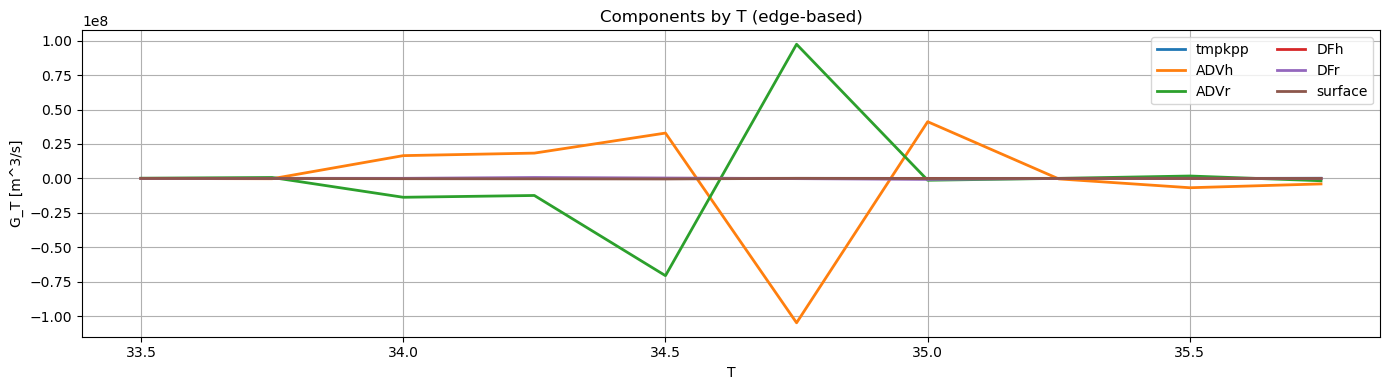

In [57]:
GtermsS = plot_figure4_components(
    SALT,
    boundsS.flatten(),
    binmidS.flatten(),
    binwidthS1.flatten(),
    mask=mymsk3d,                 # optional
    tendency_name="tmptend",      # change if your tendency is named differently
    tmpkpp=tmpkppS,
    ADVh=ADVhS,
    ADVr=ADVrS,
    DFh=DFhS,
    DFr=DFrS,
    surface=Ft_surftestS,
)

## Create the transformation plot from GtermsS and GtermsT

In [58]:
binwidthT1tile.shape
binwidthS1tile.shape

(111, 111)

In [59]:
eps = 1e-30
names = ['tmpkpp','ADVh','ADVr','DFh','DFr','surface']

dT = binwidthT1
dS = binwidthS1
dTtile = dT[:, None]
dStile = dS[None, :]

W_terms = {}
for name in names:
    GT_vol = np.asarray(GtermsT[name]) / binwidthS1      # m^3/s/PSU
    GS_vol = np.asarray(GtermsS[name]) / binwidthT1      # m^3/s/degC

    thisTS = np.zeros((nT-1,nS-1))
    
    for t in range(nT-1):
        for s in range(nS-1):
            getGT = GT_vol[t] / binwidthT1[t]     # m^3/s/PSU/degC
            getGS = GS_vol[s] / binwidthS1[s]     # m^3/s/PSU/degC
            
            thisTS[t,s] += getGT + getGS

    W_terms[name] = thisTS
            

Wsum = sum(W_terms[n] for n in names)
target = dVdt / (dTtile * dStile)


## this is clearly wrong but I think we can replicate the same way as we did before (looping through the terms) and using binwidthS1 and binwidthT1

In [60]:
ffac = 1e-6

In [61]:
# THESE ARE VERIFIED AS MATCHING THE LAYERS PACKAGE

JtermsT = np.zeros((6,nS-1,nT-1))

# get the data (will be the same for all points)
aT = ADVhT
bT = ADVrT
cT = DFhT
dT = DFrT
eT = Ft_surftestT
fT = tmpkppT

for i,j in zip(ysmsk,xsmsk):

    # loop through the z values and see if we can plot
    for k in range(nz):                 # stop at second to last level for 
        iTpt = int(binned_theta[k,i,j])             # these are already binned by the bins edges
        iSpt = int(binned_salinity[k,i,j])

        # save the J terms for here for the single point   
        JADVTh = (aT[k,i,j]) / binwidthT1[iTpt] / binwidthS1[iSpt] * ffac             # Sv/PSU/degC
        JADVTr = (bT[k,i,j]) / binwidthT1[iTpt] / binwidthS1[iSpt] * ffac              # Sv/PSU/degC
        JDFTh = (cT[k,i,j]) / binwidthT1[iTpt] / binwidthS1[iSpt] * ffac               # Sv/PSU/degC
        JDFTr = (dT[k,i,j]) / binwidthT1[iTpt] / binwidthS1[iSpt] * ffac              # Sv/PSU/degC
        JsurfT = (eT[k,i,j]) / binwidthT1[iTpt] / binwidthS1[iSpt] * ffac               # Sv/PSU/degC
        JkppT = (fT[k,i,j]) / binwidthT1[iTpt] / binwidthS1[iSpt] * ffac               # Sv/PSU/degC

        # set these in meshes so we can plot
        c = 0
        for valT in (np.array([JADVTh,JADVTr,JDFTh,JDFTr,JsurfT,JkppT])):
            #print(valT)
            JtermsT[c,iSpt,iTpt] += valT
            c += 1


JtermsS = np.zeros((6,nS-1,nT-1))


# get the data (will be the same for all points)
aS = ADVhS  # this is in PSU.m^3/s
bS = ADVrS
cS = DFhS
dS = DFrS
eS = Ft_surftestS
fS = tmpkppS

for i,j in zip(ysmsk,xsmsk):

    # loop through the z values and see if we can plot
    for k in range(nz):                 # stop at second to last level for 
        iTpt = int(binned_theta[k,i,j])             # these are already binned by the bins edges
        iSpt = int(binned_salinity[k,i,j])

        # save the J terms for here for the single point   
        JADVSh = (aS[k,i,j]) / binwidthT1[iTpt] / binwidthS1[iSpt] * ffac             # Sv/PSU/degC
        JADVSr = (bS[k,i,j]) / binwidthT1[iTpt] / binwidthS1[iSpt] * ffac              # Sv/PSU/degC
        JDFSh = (cS[k,i,j]) / binwidthT1[iTpt] / binwidthS1[iSpt] * ffac               # Sv/PSU/degC
        JDFSr = (dS[k,i,j]) / binwidthT1[iTpt] / binwidthS1[iSpt] * ffac              # Sv/PSU/degC
        JsurfS = (eS[k,i,j]) / binwidthT1[iTpt] / binwidthS1[iSpt] * ffac               # Sv/PSU/degC
        JkppS = (fS[k,i,j]) / binwidthT1[iTpt] / binwidthS1[iSpt] * ffac               # Sv/PSU/degC

        # set these in meshes so we can plot
        c = 0
        for valS in (np.array([JADVSh,JADVSr,JDFSh,JDFSr,JsurfS,JkppS])):
            #print(valT)
            JtermsS[c,iSpt,iTpt] += valS
            c += 1

In [62]:
# Load the JtermsT from layers and see if this is the same

In [63]:
iwet_mine = np.where(~np.isnan(mymsk_1d))
iwet_mine[0].shape
iwet_mine = iwet_mine[0]

In [64]:
LwetC2d = np.count_nonzero(mygrid['hFacC'][0])

In [65]:
np.count_nonzero(mygrid['hFacC'][0])

40500

(-2.0, 8.0)

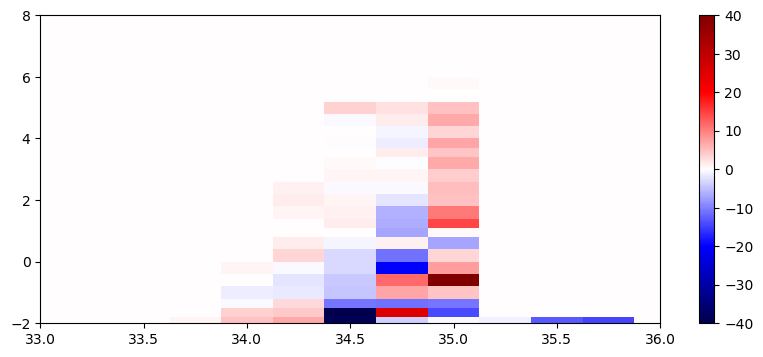

In [66]:
plt.pcolormesh(Sbin,Tbin,np.nansum(JtermsS,axis=0),cmap='seismic',vmin=-40,vmax=40)
plt.colorbar()
plt.xlim(33,36)
plt.ylim(-2,8)

(-2.0, 8.0)

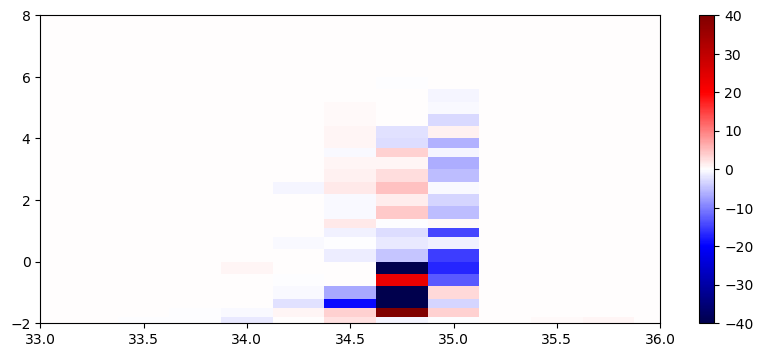

In [67]:
plt.pcolormesh(Sbin,Tbin,np.nansum(JtermsT,axis=0),cmap='seismic',vmin=-40,vmax=40)
plt.colorbar()
plt.xlim(33,36)
plt.ylim(-2,8)

In [68]:
def calc_UV_conv_TS(JtermsS, JtermsT, binwidthS1tile, binwidthT1tile, bc="zero"):
    """
    Compute convergence in TS space with same-shape output.
    JtermsS, JtermsT: arrays shaped (nterms, nS, nT)
    binwidthS1tile, binwidthT1tile: broadcastable to (nS, nT)
    bc: "zero" (default) or "periodic"
    """
    conv = np.zeros_like(JtermsS)
    convUa = np.zeros_like(JtermsS)
    convVa = np.zeros_like(JtermsS)
    nterms = JtermsS.shape[0]

    for i in range(nterms):
        JS = JtermsS[i]  # flux along S-axis   m^3/s/degC
        JT = JtermsT[i]  # flux along T-axis   m^3/s/PSU

        # same-shape arrays
        convU = np.zeros_like(JS)
        convV = np.zeros_like(JT)

        # interior differences (lose one neighbor, keep shape by assigning into interior)
        convU[:, :-1] = JS[:, :-1] - JS[:, 1:]      # d/dS of S-flux
        convV[:-1, :] = JT[:-1, :] - JT[1:, :]      # d/dT of T-flux

        convU[:, -1] = 0.0
        convV[-1, :] = 0.0

        # normalize by bin widths (broadcasts)
        convU = convU / binwidthS1tile       # m/s/degC/PSU
        convV = convV / binwidthT1tile       # m/s/PSU/degC

        # total convergence for this term
        conv[i] = convU + convV
        convUa[i] = convU
        convVa[i] = convV

    return conv,convUa,convVa

TSconv,convU,convV = calc_UV_conv_TS(JtermsS, JtermsT, binwidthS1tile, binwidthT1tile)

(-2.0, 10.0)

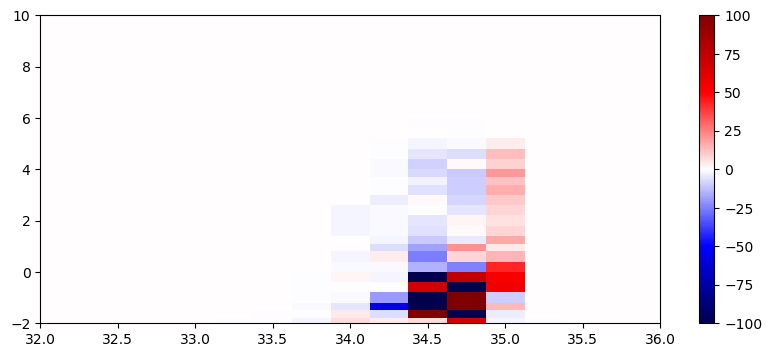

In [72]:
plt.pcolormesh(Sbin,Tbin,np.nansum(-TSconv[2:],axis=0),cmap='seismic',vmin=-100,vmax=100)
plt.colorbar()
plt.xlim(32,36)
plt.ylim(-2,10)

In [276]:

# def calc_UV_conv_TS(JtermsS, JtermsT, binwidthS, binwidthT, bc="zero"):
#     """
#     rows = salinity (S), cols = temperature (T)
#     JtermsS: (nterms, nS, nT)   intensive flux along S, units Sv/degC
#     JtermsT: (nterms, nS, nT)   intensive flux along T, units Sv/PSU
#     binwidthS, binwidthT: broadcastable to (nS, nT), widths in PSU and degC
#     bc: "zero" (zero normal flux at outer boundary) or "periodic"
#     Returns:
#       conv  : (nterms, nS, nT)  = -∇·J in Sv (per bin dV/dt from J)
#       convS : S-component contribution in Sv
#       convT : T-component contribution in Sv
#     """
#     nterms, nS, nT = JtermsS.shape
#     conv  = np.zeros_like(JtermsS)
#     convS = np.zeros_like(JtermsS)
#     convT = np.zeros_like(JtermsS)

#     for k in range(nterms):
#         JS_int = JtermsS[k]  # Sv/degC (intensive per T width)
#         JT_int = JtermsT[k]  # Sv/PSU  (intensive per S width)

#         # --- Build face-centered INTENSIVE fluxes ---
#         # S-faces lie between S-bins -> shape (nS+1, nT), average along S (rows)
#         JS_face_int = np.zeros((nS+1, nT))
#         JS_face_int[1:-1, :] = 0.5 * (JS_int[:-1, :] + JS_int[1:, :])

#         # T-faces lie between T-bins -> shape (nS, nT+1), average along T (cols)
#         JT_face_int = np.zeros((nS, nT+1))
#         JT_face_int[:, 1:-1] = 0.5 * (JT_int[:, :-1] + JT_int[:, 1:])

#         if bc == "periodic":
#             # Wrap in S for JS, wrap in T for JT
#             JS_face_int[0,  :] = 0.5 * (JS_int[-1, :] + JS_int[0, :])
#             JS_face_int[-1, :] = JS_face_int[0, :]

#             JT_face_int[:, 0]  = 0.5 * (JT_int[:, -1] + JT_int[:, 0])
#             JT_face_int[:, -1] = JT_face_int[:, 0]
#         else:  # zero normal flux
#             JS_face_int[0,  :] = 0.0
#             JS_face_int[-1, :] = 0.0
#             JT_face_int[:, 0]  = 0.0
#             JT_face_int[:, -1] = 0.0

#         # --- Orthogonal widths at faces (for intensive->extensive) ---
#         # Width orthogonal to JS (i.e., ΔT) at S-faces: average along S
#         dT_face = np.zeros_like(JS_face_int)
#         dT_face[1:-1, :] = 0.5 * (binwidthT[:-1, :] + binwidthT[1:, :])
#         if bc == "periodic":
#             dT_face[0,  :] = 0.5 * (binwidthT[-1, :] + binwidthT[0, :])
#             dT_face[-1, :] = dT_face[0, :]
#         # (for zero-flux BC, dT_face at boundary won't matter because flux is zero)

#         # Width orthogonal to JT (i.e., ΔS) at T-faces: average along T
#         dS_face = np.zeros_like(JT_face_int)
#         dS_face[:, 1:-1] = 0.5 * (binwidthS[:, :-1] + binwidthS[:, 1:])
#         if bc == "periodic":
#             dS_face[:, 0]  = 0.5 * (binwidthS[:, -1] + binwidthS[:, 0])
#             dS_face[:, -1] = dS_face[:, 0]

#         # --- Convert to EXTENSIVE face fluxes (Sv) ---
#         JS_face = JS_face_int * dT_face   # Sv
#         JT_face = JT_face_int * dS_face   # Sv

#         # --- Divergence in per-bin Sv ---
#         # ∂/∂S term: difference of S-face fluxes along S (rows)
#         dJSdS = JS_face[1:, :] - JS_face[:-1, :]      # (nS, nT)
#         # ∂/∂T term: difference of T-face fluxes along T (cols)
#         dJTdT = JT_face[:, 1:] - JT_face[:, :-1]      # (nS, nT)

#         # -∇·J = per-bin dV/dt from these J terms (Sv)
#         convS[k] = -dJSdS
#         convT[k] = -dJTdT
#         conv[k]  = convS[k] + convT[k]

#     return conv, convS, convT
# TSconv,convU,convV = calc_UV_conv_TS(JtermsS, JtermsT, binwidthS1tile, binwidthT1tile)

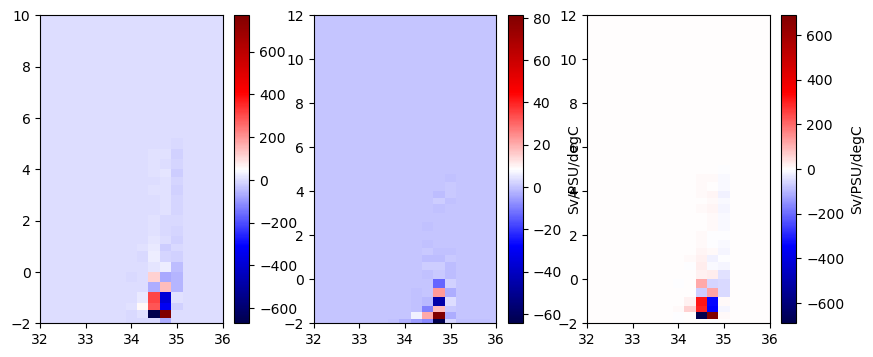

In [277]:
fig = plt.figure()
vlev = 5

ax = plt.subplot(131)
cb = ax.pcolormesh(Sbin,Tbin,np.nansum(TSconv[2:],axis=0),cmap='seismic')#,vmin=-vlev,vmax=vlev)
ax.set_xlim(32,36)
ax.set_ylim(-2,10)
plt.colorbar(cb)

ax = plt.subplot(132)
cb = ax.pcolormesh(Sbin,Tbin,np.nansum(convU[2:],axis=0),cmap='seismic')#,vmin=-vlev,vmax=vlev)
ax.set_xlim(32,36)
ax.set_ylim(-2,12)
plt.colorbar(cb,label="Sv/PSU/degC")

ax = plt.subplot(133)
cb = ax.pcolormesh(Sbin,Tbin,np.nansum(convV[2:],axis=0),cmap='seismic')#,vmin=-vlev,vmax=vlev)
ax.set_xlim(32,36)
ax.set_ylim(-2,12)
plt.colorbar(cb,label="Sv/PSU/degC")

In [278]:

# def ts_divergence(J_S, J_T, dS, dT, bc="zero"):
#     """
#     Divergence in TS-space at cell centers:
#       D = d(J_S)/dS + d(J_T)/dT
#     J_S: (..., nS, nT)   [Sv/PSU]   flux along +S (S-faces)
#     J_T: (..., nS, nT)   [Sv/°C]    flux along +T (T-faces)
#     dS, dT: broadcastable to (..., nS, nT) containing local bin widths
#     bc: "zero" (no-flux edges) or "periodic"
#     """
#     # d(J_S)/dS  (backward diff in S)
#     if bc == "periodic":
#         JS_left = np.roll(J_S, shift=1, axis=-2)   # neighbor at i-1
#     else:  # zero-flux edges: left face of i=0 set equal to J_S[0]
#         JS_left = np.concatenate([J_S[..., :1, :], J_S[..., :-1, :]], axis=-2)
#     dJSdS = (J_S - JS_left) / dS

#     # d(J_T)/dT  (backward diff in T)
#     if bc == "periodic":
#         JT_down = np.roll(J_T, shift=1, axis=-1)   # neighbor at j-1
#     else:  # zero-flux edges: bottom face of j=0 set equal to J_T[:,0]
#         JT_down = np.concatenate([J_T[..., :, :1], J_T[..., :, :-1]], axis=-1)
#     dJTdT = (J_T - JT_down) / dT

#     return dJSdS + dJTdT  # [Sv/(PSU·°C)]
    
# TSconv = ts_divergence(JtermsS, JtermsT, binwidthS1tile, binwidthT1tile)

In [279]:
# fig = plt.figure()
# vlev = 100

# ax = plt.subplot(131)
# cb = ax.pcolormesh(Sbin,Tbin,np.nansum(TSconv[2:],axis=0),cmap='seismic',vmin=-vlev,vmax=vlev)
# ax.set_xlim(32,36)
# ax.set_ylim(-2,10)
# plt.colorbar(cb)

# ax = plt.subplot(132)
# cb = ax.pcolormesh(Sbin,Tbin,np.nansum(convU[2:],axis=0),cmap='seismic',vmin=-vlev,vmax=vlev)
# ax.set_xlim(32,36)
# ax.set_ylim(-2,12)
# plt.colorbar(cb,label="Sv/PSU/degC")

# ax = plt.subplot(133)
# cb = ax.pcolormesh(Sbin,Tbin,np.nansum(convV[2:],axis=0),cmap='seismic',vmin=-vlev,vmax=vlev)
# ax.set_xlim(32,36)
# ax.set_ylim(-2,12)
# plt.colorbar(cb,label="Sv/PSU/degC")

In [280]:

test = np.nansum(-TSconv[2:],axis=0)
total = np.nansum(-TSconv, axis=0)          # shape (nS, nT)

# avoid divide-by-zero; keep NaNs where total is zero/NaN
eps = 0.0
frac_signed   = np.divide(test, total, where=np.isfinite(total) & (np.abs(total) > eps))

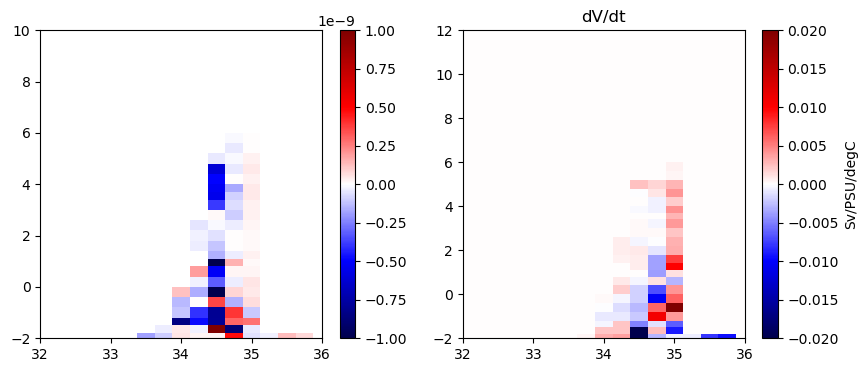

In [308]:
fig = plt.figure()

ax = plt.subplot(121)
cb = ax.pcolormesh(Sbin,Tbin,np.nansum(-TSconv[2:],axis=0)/RACbin,cmap='seismic',vmin=-1e-9,vmax=1e-9)
# cb = ax.pcolormesh(Sbin,Tbin,frac_signed,cmap='seismic',vmin=-4,vmax=4)

ax.set_xlim(32,36)
ax.set_ylim(-2,10)
plt.colorbar(cb)

ax = plt.subplot(122)
cb = ax.pcolormesh(Sbin,Tbin,dVdt*1e-6 / binwidthS1tile / binwidthT1tile,cmap='seismic',vmin=-.02,vmax=.02)
ax.set_title("dV/dt")
ax.set_xlim(32,36)
ax.set_ylim(-2,12)
plt.colorbar(cb,label="Sv/PSU/degC")

In [289]:
dVdtscaled = dVdt*1e-6 / binwidthS1tile / binwidthT1tile

## units seem like something is going wrong -- try to compare with gates

We did verify that G_T with the gates calculated from ADV_TH is the same as from UVEL and VVEL

In [290]:
# get the gateways as the same diagram

In [291]:
# just try to load the plot for one gateway
THETA_face = np.zeros_like(THETA)

# ---- U-faces (collocated with UVEL[j, i]): average in i-direction ----
for j, i in zip(y_bsoh, x_bsoh):
    if i > 0:
        # face between (j, i-1) and (j, i)
        THETA_face[:, j, i] = 0.5 * (THETA[:, j, i] + THETA[:, j, i-1])

# ---- V-faces (collocated with VVEL[j, i]): average in j-direction ----
for j, i in zip(y_bsov, x_bsov):
    if j > 0:
        # face between (j-1, i) and (j, i)
        THETA_face[:, j-1, i] = 0.5 * (THETA[:, j, i] + THETA[:, j-1, i])
THETA_face[THETA_face==0] = np.nan


In [292]:
y_bso_all = np.array([]).astype(int)
x_bso_all = np.array([]).astype(int)

In [293]:
ADVx_TH = ADVx_TH.reshape((nz,ny,nx))
ADVy_TH = ADVy_TH.reshape((nz,ny,nx))

ADV_west = np.zeros((nz,ny,nx))
for j,i, in zip(y_bsoh,x_bsoh):
    ADV_west[:,j,i] += ADVx_TH[:,j,i]       # + into basin
    y_bso_all,x_bso_all = np.append(y_bso_all,j),np.append(x_bso_all,i)
for j,i, in zip(y_bsov,x_bsov):
    ADV_west[:,j-1,i] -= ADVy_TH[:,j,i]
    y_bso_all,x_bso_all = np.append(y_bso_all,j-1),np.append(x_bso_all,i)


THETA_gate = np.zeros((nz,ny,nx))
for j,i, in zip(y_bsoh,x_bsoh):
    THETA_gate[:,j,i] = THETA[:,j,i]       # + into basin
for j,i, in zip(y_bsov,x_bsov):
    THETA_gate[:,j-1,i] = THETA[:,j-1,i]

In [294]:
volume_transp = ADV_west/THETA_face                     # this is now in m^3/s

In [295]:
zsb,ysb,xsb = np.where(~np.isnan(volume_transp))[0],np.where(~np.isnan(volume_transp))[1],np.where(~np.isnan(volume_transp))[2]

In [296]:
y_bso_all

array([145, 146, 147, 148, 149, 185, 185, 185, 185, 185, 185, 185, 185,
       185, 185])

In [297]:
# I don't think this is the correct way to do this (I think this is repeating indices

testbso = np.array([])
J_BSO = np.zeros((nS-1,nT-1))
J_BSOnn = np.zeros((nS-1,nT-1))
for i,j in zip(y_bso_all,x_bso_all):

    # loop through the z values and see if we can plot
    for k in range(nz):                 # stop at second to last level for 
        iTpt = int(binned_theta[k,i,j])             # these are already binned by the bins edges
        iSpt = int(binned_salinity[k,i,j])

        J_BSO[iSpt,iTpt] += (volume_transp[k,i,j]) #/ binwidthT1[iTpt] / binwidthS1[iSpt] * 1e-6             # Sv/PSU/degC
        J_BSOnn[iSpt,iTpt] += (volume_transp[k,i,j])             # m^3/s

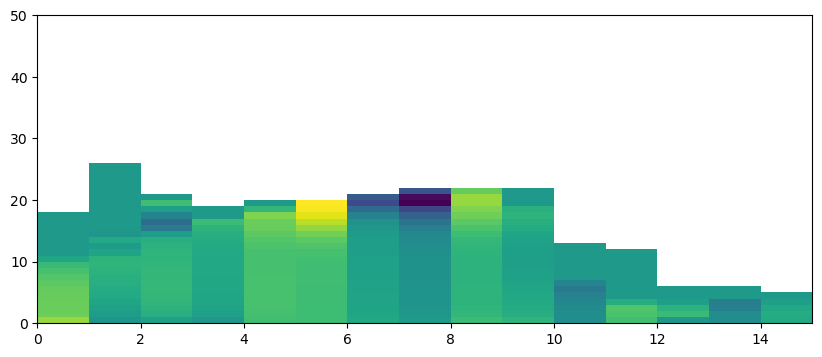

In [298]:
plt.pcolormesh(volume_transp[:, y_bso_all, x_bso_all])

In [299]:
vt_subset = volume_transp[:, y_bso_all, x_bso_all]     # shape: (nz, n_gate_pts)

sum_subset = np.nansum(vt_subset)          # what testbso *should* sum to
sum_whole   = np.nansum(volume_transp)     # whole domain

print(sum_subset, sum_whole)

1798289.1216083912 1798289.1216083914


In [300]:
J_BSO = np.zeros((nS-1, nT-1), dtype=float)
sum = 0
for i, j in zip(y_bso_all, x_bso_all):
    for k in range(nz):
        tbin = int(binned_theta[k, i, j])
        sbin = int(binned_salinity[k, i, j])

        # skip out-of-range or non-finite points
        if not (0 <= tbin < nT-1 and 0 <= sbin < nS-1):
            continue
        v = volume_transp[k, i, j]
        if not np.isfinite(v):
            continue

        J_BSO[sbin, tbin] += v  # accumulate transport (m^3/s)
        sum += v

# Convert to density if desired:
J_BSOnn = J_BSO
J_BSO = (J_BSO * 1e-6) / (binwidthS1[:, None] * binwidthT1[None, :])  # Sv/(PSU·°C)


In [301]:
# plt.pcolormesh(J_BSO,cmap='seismic',vmin=-10,vmax=10)
# plt.colorbar()
np.nansum(J_BSOnn)  # this is the same as the overall volume transport

# we need to fix the indices below to fix this

1798289.1216083914

In [302]:
y_fjnz_all,x_fjnz_all = np.array([]).astype(int),np.array([]).astype(int)

ADV_FJNZ = np.zeros((nz,ny,nx))
for j,i, in zip(y_fjnzv,x_fjnzv):
    ADV_FJNZ[:,j,i-1] -= ADVx_TH[:,j,i]       # + into basin
    y_fjnz_all,x_fjnz_all = np.append(y_fjnz_all,j),np.append(x_fjnz_all,i-1)

# just try to load the plot for one gateway
THETA_facefjnz = np.zeros_like(THETA)

# ---- U-faces (collocated with UVEL[j, i]): average in i-direction ----
for j, i in zip(y_fjnzv, x_fjnzv):
    if i > 0:
        # face between (j, i-1) and (j, i)
        THETA_facefjnz[:, j, i-1] = 0.5 * (THETA[:, j, i] + THETA[:, j, i-1])

vol_transp_fjnz = ADV_FJNZ/THETA_facefjnz


# get the TS diagram for this
J_FJNZ = np.zeros((nS-1,nT-1))
for i,j in zip(y_fjnz_all,x_fjnz_all):

    # loop through the z values and see if we can plot
    for k in range(nz):                 # stop at second to last level for 
        iTpt = int(binned_theta[k,i,j])             # these are already binned by the bins edges
        iSpt = int(binned_salinity[k,i,j])

        # save the J terms for here for the single point   
        J_FJNZhere = (vol_transp_fjnz[k,i,j]) / binwidthT1[iTpt] / binwidthS1[iSpt] * 1e-6             # Sv/PSU/degC

        J_FJNZ[iSpt,iTpt] += J_FJNZhere

In [303]:
# do the same for nzru
y_nzru_all,x_nzru_all = np.array([]).astype(int),np.array([]).astype(int)

ADV_NZRU = np.zeros((nz,ny,nx))
for j,i, in zip(y_nzruv,x_nzruv):
    ADV_NZRU[:,j,i-1] -= ADVx_TH[:,j,i]       # + into basin
    y_nzru_all,x_nzru_all = np.append(y_nzru_all,j),np.append(x_nzru_all,i-1)  # indices where we write to/budget


# just try to load the plot for one gateway
THETA_facenzru = np.zeros_like(THETA)

# ---- U-faces (collocated with UVEL[j, i]): average in i-direction ----
for j, i in zip(y_nzruv, x_nzruv):
    if i > 0:
        # face between (j, i-1) and (j, i)
        THETA_facefjnz[:, j, i-1] = 0.5 * (THETA[:, j, i] + THETA[:, j, i-1])

vol_transp_nzru = ADV_NZRU/THETA_facefjnz

# get the TS diagram for this
J_NZRU = np.zeros((nS-1,nT-1))
for i,j in zip(y_nzru_all,x_nzru_all):

    # loop through the z values and see if we can plot
    for k in range(nz):                 # stop at second to last level for 
        iTpt = int(binned_theta[k,i,j])             # these are already binned by the bins edges
        iSpt = int(binned_salinity[k,i,j])

        # save the J terms for here for the single point   
        J_NZRUhere = (vol_transp_nzru[k,i,j]) / binwidthT1[iTpt] / binwidthS1[iSpt] * 1e-6             # Sv/PSU/degC

        J_NZRU[iSpt,iTpt] += J_NZRUhere

In [304]:
# do the same also for SP x_spfjh y_spfjh x_spfjv y_spfjv

y_spfj_all,x_spfj_all = np.array([]).astype(int),np.array([]).astype(int)

ADV_SPFJ = np.zeros((nz,ny,nx))
for j,i, in zip(y_spfjh,x_spfjh):
    ADV_SPFJ[:,j,i-1] -= ADVx_TH[:,j,i]       # + into basin
    y_spfj_all,x_spfj_all = np.append(y_spfj_all,j),np.append(x_spfj_all,i-1)  # indices where we write to/budget

for j,i, in zip(y_spfjv,x_spfjv):
    ADV_SPFJ[:,j-1,i] -= ADVy_TH[:,j,i]
    y_spfj_all,x_spfj_all = np.append(y_spfj_all,j-1),np.append(x_spfj_all,i)  # indices where we write to/budget

# just try to load the plot for one gateway
THETA_facespfj = np.zeros_like(THETA)

# ---- U-faces (collocated with UVEL[j, i]): average in i-direction ----
for j, i in zip(y_spfjh, x_spfjh):
    if i > 0:
        # face between (j, i-1) and (j, i)
        THETA_facespfj[:, j, i-1] = 0.5 * (THETA[:, j, i] + THETA[:, j, i-1])

for j, i in zip(y_spfjv, x_spfjv):
    if i > 0:
        # face between (j, i-1) and (j, i)
        THETA_facespfj[:, j-1, i] = 0.5 * (THETA[:, j, i] + THETA[:, j-1, i])

vol_transp_spfj = ADV_SPFJ/THETA_facespfj

# get the TS diagram for this
J_SPFJ = np.zeros((nS-1,nT-1))
for i,j in zip(y_spfj_all,x_spfj_all):

    # loop through the z values and see if we can plot
    for k in range(nz):                 # stop at second to last level for 
        iTpt = int(binned_theta[k,i,j])             # these are already binned by the bins edges
        iSpt = int(binned_salinity[k,i,j])

        # save the J terms for here for the single point   
        J_SPFJhere = (vol_transp_spfj[k,i,j]) / binwidthT1[iTpt] / binwidthS1[iSpt] * 1e-6             # Sv/PSU/degC

        J_SPFJ[iSpt,iTpt] += J_SPFJhere

In [305]:
Jtermstest = np.nansum(-TSconv[2:],axis=0)
# Jtermstest = np.nansum(JtermsAll[:],axis=0)

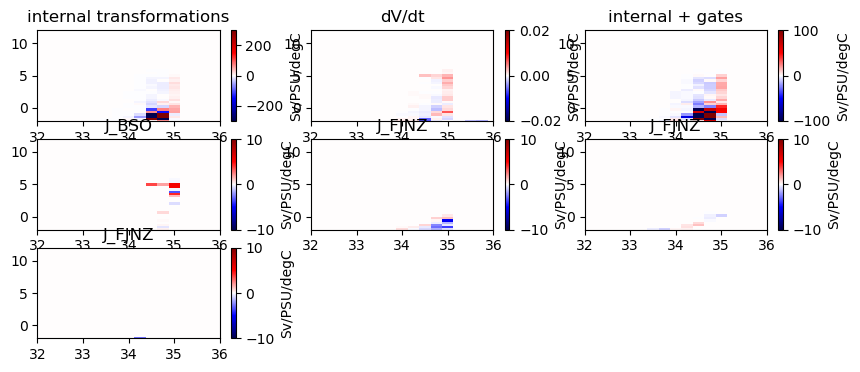

In [306]:
fig = plt.figure()
vlevgate = 10

ax = plt.subplot(331)
cb = ax.pcolormesh(Sbin,Tbin,Jtermstest,cmap='seismic',vmin=-300,vmax=300)
ax.set_title("internal transformations")
ax.set_xlim(32,36)
ax.set_ylim(-2,12)
plt.colorbar(cb,label="Sv/PSU/degC")

ax = plt.subplot(332)
cb = ax.pcolormesh(Sbin,Tbin,target*1e-6,cmap='seismic',vmin=-.02,vmax=.02)
ax.set_title("dV/dt")
ax.set_xlim(32,36)
ax.set_ylim(-2,12)
plt.colorbar(cb,label="Sv/PSU/degC")

ax = plt.subplot(333)
cb = ax.pcolormesh(Sbin,Tbin,Jtermstest + J_BSO + J_FJNZ + J_NZRU + J_SPFJ,cmap='seismic',vmin=-100,vmax=100)
ax.set_title("internal + gates")
ax.set_xlim(32,36)
ax.set_ylim(-2,12)
plt.colorbar(cb,label="Sv/PSU/degC")

ax = plt.subplot(334)
cb = ax.pcolormesh(Sbin,Tbin,J_BSO,cmap='seismic',vmin=-vlevgate,vmax=vlevgate)
ax.set_title("J_BSO")
ax.set_xlim(32,36)
ax.set_ylim(-2,12)
plt.colorbar(cb,label="Sv/PSU/degC")

ax = plt.subplot(335)
cb = ax.pcolormesh(Sbin,Tbin,J_FJNZ,cmap='seismic',vmin=-vlevgate,vmax=vlevgate)
ax.set_title("J_FJNZ")
ax.set_xlim(32,36)
ax.set_ylim(-2,12)
plt.colorbar(cb,label="Sv/PSU/degC")

ax = plt.subplot(336)
cb = ax.pcolormesh(Sbin,Tbin,J_SPFJ,cmap='seismic',vmin=-vlevgate,vmax=vlevgate)
ax.set_title("J_FJNZ")
ax.set_xlim(32,36)
ax.set_ylim(-2,12)
plt.colorbar(cb,label="Sv/PSU/degC")

ax = plt.subplot(337)
cb = ax.pcolormesh(Sbin,Tbin,J_NZRU,cmap='seismic',vmin=-vlevgate,vmax=vlevgate)
ax.set_title("J_FJNZ")
ax.set_xlim(32,36)
ax.set_ylim(-2,12)
plt.colorbar(cb,label="Sv/PSU/degC")

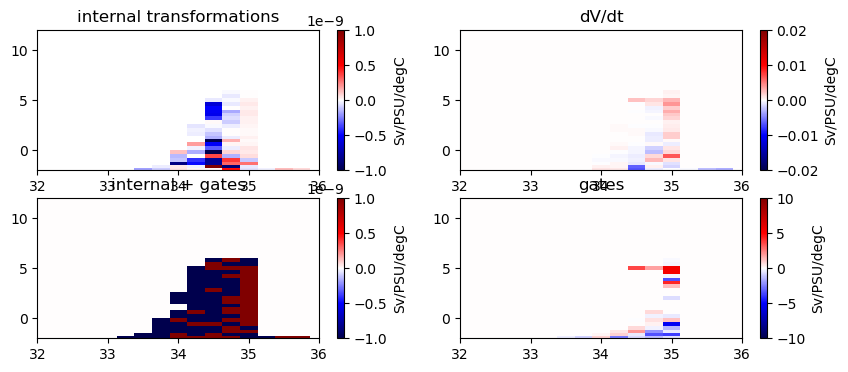

In [310]:
fig = plt.figure()
vlev = 1e-9
dvtest = 1

ax = plt.subplot(221)
cb = ax.pcolormesh(Sbin,Tbin,Jtermstest/RACbin,cmap='seismic',vmin=-vlev,vmax=vlev)
ax.set_title("internal transformations")
ax.set_xlim(32,36)
ax.set_ylim(-2,12)
plt.colorbar(cb,label="Sv/PSU/degC")

ax = plt.subplot(222)
cb = ax.pcolormesh(Sbin,Tbin,target*1e-6,cmap='seismic',vmin=-.02,vmax=.02)
ax.set_title("dV/dt")
ax.set_xlim(32,36)
ax.set_ylim(-2,12)
plt.colorbar(cb,label="Sv/PSU/degC")

ax = plt.subplot(223)
cb = ax.pcolormesh(Sbin,Tbin,(Jtermstest + J_BSO + J_FJNZ + J_NZRU + J_SPFJ),cmap='seismic',vmin=-vlev,vmax=vlev)
ax.set_title("internal + gates")
ax.set_xlim(32,36)
ax.set_ylim(-2,12)
plt.colorbar(cb,label="Sv/PSU/degC")

ax = plt.subplot(224)
cb = ax.pcolormesh(Sbin,Tbin,(J_BSO + J_FJNZ + J_NZRU + J_SPFJ),cmap='seismic',vmin=-10,vmax=10)
ax.set_title("gates")
ax.set_xlim(32,36)
ax.set_ylim(-2,12)
plt.colorbar(cb,label="Sv/PSU/degC")

In [238]:
a = np.nansum((Jtermstest + J_BSO + J_FJNZ + J_NZRU + J_SPFJ),axis=0)   # sum in salt
b = np.nansum((dVdt*1e-6 / binwidthS1tile / binwidthT1tile),axis=0)

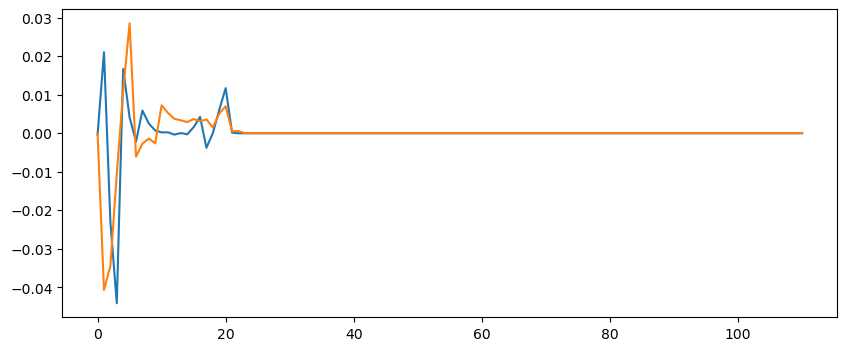

In [241]:
plt.plot(a/1000,label="RHS")
plt.plot(b,label="LHS")

In [232]:
a = np.nansum((Jtermstest + J_BSO + J_FJNZ + J_NZRU + J_SPFJ),axis=1)   # sum in theta
b = np.nansum((dVdt*1e-6 / binwidthS1tile / binwidthT1tile),axis=1)

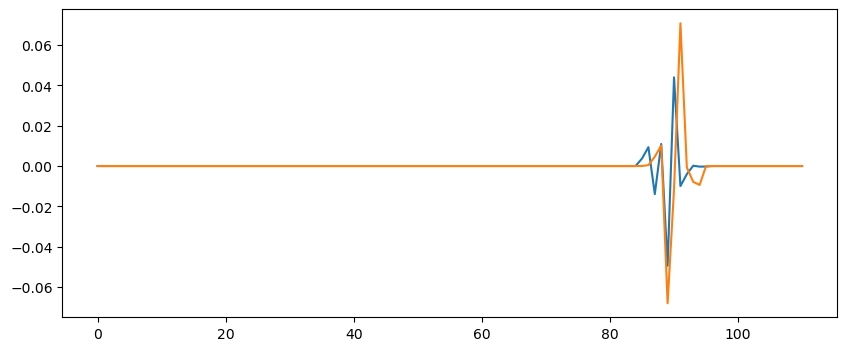

In [235]:
plt.plot(-a/100,label="RHS")
plt.plot(b,label="LHS")

## Validate J_BSO (etc other gates) with the actual volume transport through the gates

In [117]:
# validate the J_BSO first

THETA_face.shape
ADV_west.shape   # degC.m^3/s

# J_BSO has already been normalized by the face (we can go back and recompute without)
np.nansum(J_BSOnn)

36066261.05150073

In [118]:
np.nansum(ADV_west/THETA_face)

1798289.1216083914

In [ ]:
# J_BSO 

In [ ]:
# let's get the J terms convergence in terms of nablaJ, nablaJ*ds*dt, and nablaJ*ds*dt*area

In [ ]:
# we need the area binned to TS space

# can we compute the same M term for volume transport with UVEL and VVELMASS

In [245]:
# create the volume and bin this
DXG3d = np.tile(mygrid['DXG'][np.newaxis,:,:],(nz,1,1))
DYG3d = np.tile(mygrid['DYG'][np.newaxis,:,:],(nz,1,1))
DRF3d = np.tile(mygrid['DRF'][:,np.newaxis,np.newaxis],(1,ny,nx))

# grab the UVEL and VVEL for this timestep
file_name = "budg3d_hflux_set2"
meta_budg3d_hflux_set2 = parsemeta(dirdiags + file_name + "." + tsstr[0] + ".meta")
fldlist = np.array(meta_budg3d_hflux_set2["fldList"])
varnames = np.array(["UVELMASS","VVELMASS"])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    recs = np.append(recs, irec[0][0])
UVELMASS,its,meta = rdmds(os.path.join(dirdiags, file_name),t2,returnmeta=True,rec=recs[0])
VVELMASS,its,meta = rdmds(os.path.join(dirdiags, file_name),t2,returnmeta=True,rec=recs[1])  # m/s
UVELMASS = UVELMASS.reshape(nz,ny,nx)
VVELMASS = VVELMASS.reshape(nz,ny,nx)


# create the same gateways as we do below with UVELMASS and VVELMASS
VEL_gates = {}

VEL_BSO = np.zeros((nz,ny,nx))
for j,i, in zip(y_bsoh,x_bsoh):
    VEL_BSO[:,j,i] += UVELMASS[:,j,i] * DYG3d[:,j,i] * DRF3d[:,j,i]
for j,i, in zip(y_bsov,x_bsov):
    VEL_BSO[:,j-1,i] -= VVELMASS[:,j,i] * DXG3d[:,j,i] * DRF3d[:,j,i]

VEL_FJNZ = np.zeros((nz,ny,nx))
for j,i, in zip(y_fjnzv,x_fjnzv):
    VEL_FJNZ[:,j,i-1] -= UVELMASS[:,j,i] * DYG3d[:,j,i] * DRF3d[:,j,i]      # + into basin

VEL_NZRU = np.zeros((nz,ny,nx))
for j,i, in zip(y_nzruv,x_nzruv):
    VEL_NZRU[:,j,i-1] -= UVELMASS[:,j,i] * DYG3d[:,j,i] * DRF3d[:,j,i]         # + into basin

VEL_SPFJ = np.zeros((nz,ny,nx))
for j,i, in zip(y_spfjh,x_spfjh):
    VEL_SPFJ[:,j,i-1] -= UVELMASS[:,j,i] * DYG3d[:,j,i] * DRF3d[:,j,i]         # + into basin
for j,i, in zip(y_spfjv,x_spfjv):
    VEL_SPFJ[:,j-1,i] -= VVELMASS[:,j,i] * DXG3d[:,j,i] * DRF3d[:,j,i]

zsb,ysb,xsb = np.where(VEL_BSO!=0)[0],np.where(VEL_BSO!=0)[1],np.where(VEL_BSO!=0)[2]

# get the TS diagram for this
J_BSO_vel = np.zeros((nS-1,nT-1))
for i,j in zip(ysb,xsb):

    # loop through the z values and see if we can plot
    for k in range(nz):                 # stop at second to last level for 
        iTpt = int(binned_theta[k,i,j])             # these are already binned by the bins edges
        iSpt = int(binned_salinity[k,i,j])

        # save the J terms for here for the single point   
        J_BSO_velhere = (VEL_BSO[k,i,j]) / binwidthT1[iTpt] / binwidthS1[iSpt] * 1e-6             # Sv/PSU/degC

        J_BSO_vel[iSpt,iTpt] += J_BSO_velhere

In [246]:



# do the same for the other gates and validate

zsb,ysb,xsb = np.where(VEL_FJNZ!=0)[0],np.where(VEL_FJNZ!=0)[1],np.where(VEL_FJNZ!=0)[2]
# get the TS diagram for this
VEL_FJNZ_vel = np.zeros((nS-1,nT-1))
for i,j in zip(ysb,xsb):

    # loop through the z values and see if we can plot
    for k in range(nz):                 # stop at second to last level for 
        iTpt = int(binned_theta[k,i,j])             # these are already binned by the bins edges
        iSpt = int(binned_salinity[k,i,j])

        # save the J terms for here for the single point   
        J_FJNZ_velhere = (VEL_FJNZ[k,i,j]) / binwidthT1[iTpt] / binwidthS1[iSpt] * 1e-6             # Sv/PSU/degC

        VEL_FJNZ_vel[iSpt,iTpt] += J_FJNZ_velhere

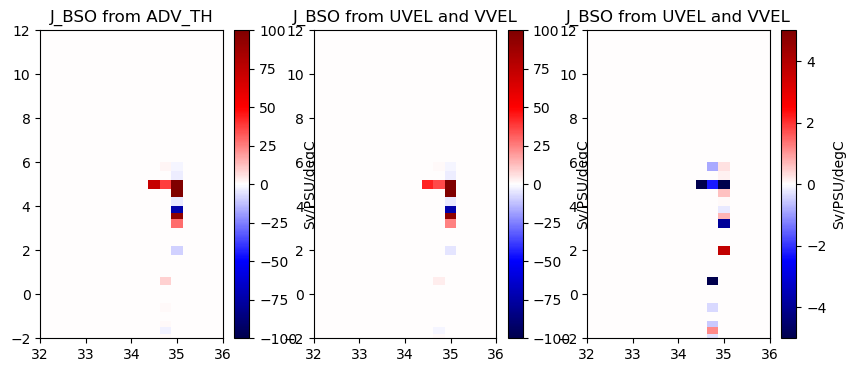

In [248]:
fig = plt.figure()

ax = plt.subplot(131)
cb = ax.pcolormesh(Sbin,Tbin,J_BSO,cmap='seismic',vmin=-100,vmax=100)
ax.set_title("J_BSO from ADV_TH")
ax.set_xlim(32,36)
ax.set_ylim(-2,12)
plt.colorbar(cb,label="Sv/PSU/degC")

ax = plt.subplot(132)
cb = ax.pcolormesh(Sbin,Tbin,J_BSO_vel,cmap='seismic',vmin=-100,vmax=100)
ax.set_title("J_BSO from UVEL and VVEL")
ax.set_xlim(32,36)
ax.set_ylim(-2,12)
plt.colorbar(cb,label="Sv/PSU/degC")

ax = plt.subplot(133)
cb = ax.pcolormesh(Sbin,Tbin,J_BSO_vel - J_BSO,cmap='seismic',vmin=-5,vmax=5)
ax.set_title("J_BSO from UVEL and VVEL")
ax.set_xlim(32,36)
ax.set_ylim(-2,12)
plt.colorbar(cb,label="Sv/PSU/degC")


# We need to validate that the heat transport we calculated here is the same as is coming through the gates.

[145 146 147 148 149]


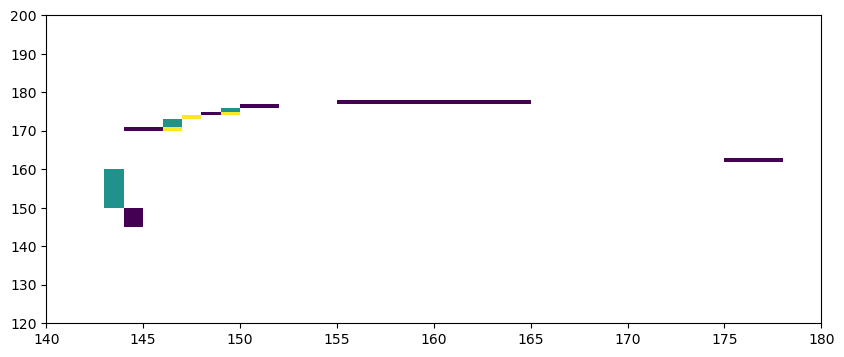

In [123]:
plt.pcolormesh(get_aste_tracer(gates_mask,nfx,nfy)[0])
plt.xlim(140,180)
plt.ylim(120,200)
print(y_bsoh)

In [127]:
# ytest = np.concatenate((y_bsoh,x_bsov))
# xtest = np.concatenate((x_bsoh,y_bsov-1))

In [128]:
# plt.pcolormesh(ADV_west[0])
# jj,ii = np.where(ADV_west[0] != 0)[0],np.where(ADV_west[0] != 0)[1]

# plt.pcolormesh(ADV_west[:,jj,ii],cmap='seismic')

# try to compute with the same method as for Gterms

In [97]:
# NOTE -- THIS IS THE SAME RESULT AS WE GOT WHEN WE CALCULATED JTERMSS AND T AS ABOVE


# def _bincount2d_sum_with_nan(iT, iS, vals, nTm1, nSm1):
#     """
#     NaN-aware per-(S,T) bin sum on integer bin indices.
#     Returns (nSm1, nTm1) with NaN where a bin had zero finite contributions.
#     """
#     # Flatten 2D indices to 1D bins
#     flat = iS.astype(np.int64) * nTm1 + iT.astype(np.int64)
#     finite = np.isfinite(vals)
#     size = nTm1 * nSm1

#     sums   = np.bincount(flat[finite], vals[finite], minlength=size).astype(float)
#     counts = np.bincount(flat[finite], None,        minlength=size).astype(float)

#     out = sums.reshape(nSm1, nTm1)
#     out[counts.reshape(nSm1, nTm1) == 0] = np.nan
#     return out

# def accumulate_J_terms_TS(
#     THETA, SALT,
#     binmidT, binmidS,
#     binwidthT1, binwidthS1,
#     *,
#     mask=None,
#     scale=1e-6,
#     **terms
# ):
#     """
#     Bin arbitrary component terms onto (S,T) *edge* bins defined by binmid arrays.

#       - Bins: binmidT[i] <= THETA < binmidT[i+1],  i=0..nT-2  (nT-1 T-edge bins)
#               binmidS[j] <= SALT  < binmidS[j+1],  j=0..nS-2  (nS-1 S-edge bins)
#       - For each term: sum values per (j,i) bin, then divide by (binwidthS1[j] * binwidthT1[i]).
#       - NaN semantics: if a bin has zero finite contributions → NaN; otherwise NaNs are ignored.

#     Returns dict: name -> array (nS-1, nT-1) in (S,T) order.
#     """
#     THETA   = np.asarray(THETA)
#     SALT    = np.asarray(SALT)
#     binmidT = np.asarray(binmidT)
#     binmidS = np.asarray(binmidS)
#     binwidthT1 = np.asarray(binwidthT1)
#     binwidthS1 = np.asarray(binwidthS1)

#     if THETA.shape != SALT.shape:
#         raise ValueError("THETA and SALT must have the same shape")
#     if mask is not None:
#         mask = np.asarray(mask)
#         if mask.shape != THETA.shape:
#             raise ValueError("mask must have the same shape as THETA/SALT")

#     nT = binmidT.size
#     nS = binmidS.size
#     nTm1 = nT - 1
#     nSm1 = nS - 1
#     if nTm1 <= 0 or nSm1 <= 0:
#         raise ValueError("binmidT and binmidS must each have length >= 2")
#     if binwidthT1.size != nTm1 or binwidthS1.size != nSm1:
#         raise ValueError("binwidthT1 must have len nT-1 and binwidthS1 must have len nS-1")

#     # Build (edge) bin indices via the mid-edge intervals
#     th = THETA.ravel()
#     sa = SALT.ravel()
#     iT = np.digitize(th, binmidT, right=False) - 1
#     iS = np.digitize(sa, binmidS, right=False) - 1

#     valid = (
#         (iT >= 0) & (iT < nTm1) &
#         (iS >= 0) & (iS < nSm1) &
#         np.isfinite(th) & np.isfinite(sa)
#     )
#     if mask is not None:
#         valid &= mask.ravel().astype(bool)

#     iT = iT[valid]
#     iS = iS[valid]

#     # Precompute 2D “cell area” in T–S space for post-division
#     denom = np.outer(binwidthS1, binwidthT1)  # (nS-1, nT-1)

#     out = {}
#     for name, arr in terms.items():
#         arr = np.asarray(arr)
#         if arr.shape != THETA.shape:
#             raise ValueError(f"term '{name}' must have shape {THETA.shape}")
#         vals = arr.ravel()[valid].astype(float)

#         # NaN-aware sum per (S,T) bin
#         summed = _bincount2d_sum_with_nan(iT, iS, vals, nTm1, nSm1)

#         # Convert to J (per-edge in T and S): divide by (ΔT * ΔS)
#         J = summed / denom

#         # Optional scaling (e.g., to Sv/PSU/°C)
#         if scale is not None:
#             J = J * scale

#         out[name] = J

#     return out

# # ---- Example wiring to match your variable names & output shape ----
# # J is a dict of (nS-1, nT-1) arrays
# J = accumulate_J_terms_TS(
#     THETA, SALT,
#     binmidT.flatten(), binmidS.flatten(),
#     binwidthT1.flatten(), binwidthS1.flatten(),
#     mask=mymsk3d,       # or mask=None
#     scale=1e-6,                # your original scaling
#     ADVhT=ADVhT*mymsk3d, ADVrT=ADVrT*mymsk3d, DFhT=DFhT*mymsk3d, DFrT=DFrT*mymsk3d, Ft_surftestT=Ft_surftestT*mymsk3d, tmpkppT=tmpkppT*mymsk3d
# )

# # If you still want a stacked array shaped (6, nS-1, nT-1) in a specific order:
# order = ["ADVhT","ADVrT","DFhT","DFrT","Ft_surftestT","tmpkppT"]
# JtermsT = np.stack([J[k] for k in order], axis=0)

# J = accumulate_J_terms_TS(
#     THETA, SALT,
#     binmidT.flatten(), binmidS.flatten(),
#     binwidthT1.flatten(), binwidthS1.flatten(),
#     mask=mymsk3d,       # or mask=None
#     scale=1e-6,                # your original scaling
#     ADVhS=ADVhS*mymsk3d, ADVrS=ADVrS*mymsk3d, DFhS=DFhS*mymsk3d, DFrS=DFrS*mymsk3d, Ft_surftestS=Ft_surftestS*mymsk3d, tmpkppS=tmpkppS*mymsk3d
# )

# # If you still want a stacked array shaped (6, nS-1, nT-1) in a specific order:
# order = ["ADVhS","ADVrS","DFhS","DFrS","Ft_surftestS","tmpkppS"]
# JtermsS = np.stack([J[k] for k in order], axis=0)
